In [1]:
import warnings
import numpy as np
import pandas as pd
import sys
import pickle
from time import time
import scipy.stats
from scipy.special import logsumexp, comb
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn

from structure.pattern import PatternMatching
from structure.utils import *
from structure.graphics import visualize_secondary_structure

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
inf = float("Inf")

In [12]:
DATA = "/home/malbranke/data/"
DATASET = "PF01353"

## CVXpy optimization

It doestn't work with quadratic forms

In [3]:
import cvxpy as cp
import scs

In [14]:
y = DATA[0]
N = y.shape[0]
y = y.flatten()
C = -cp.log(y)

In [403]:
OON = np.zeros((3*N,3*N))
for i in range(N):
    OON[3*i,3*i+1] = OON[3*i+1,3*i+2] = OON[3*i+2,3*i] = 1
OON = (OON+OON.T)/2

SUMTO1 = np.zeros((N,3*N))
for i in range(N):
    SUMTO1[i,3*i+1] = SUMTO1[i,3*i+2] = SUMTO1[i,3*i] = 1

SUM2TO1 = np.zeros((N,3*N,3*N))
for i in range(N):
    SUM2TO1[i,3*i+1,3*i+1] = SUM2TO1[i,3*i+2,3*i+2] = SUM2TO1[i,3*i,3*i] = 1
    
I, I_n = np.eye(3*N),np.eye(N)

In [209]:
def T_mat(j_in,j_out):
    T = np.zeros((3*N,3*N))
    for i in range(N-1):
        T[3*i+j_in,3*(i+1)+j_out] = 1
    return (T+T.T)/2

def Sk_mat(i,j_in,j_out,k):
    Sk = np.zeros((3*N,3*N))
    start = i+1
    stop = max(i+1+k, N)
    Sk[3*i+j_in,3*start+j_out:3*stop+j_out:3] = 1
    return (Sk+Sk.T)/2

def f(x, g):
    g1, g3, g4 = g[:3]
    g2 = g[3:3+N]
    return np.sum(x*C) + sum((g1 * OON@x + sum(g*s for g,s in zip(g2, SUMTO1)) + 
                             g3 * T_mat(1,2)@x + g4 * T_mat(2,1)@x)*x) 

def c_lamb(g):
    g1, g3, g4 = g[:3]
    g2 = g[3:3+N]
    a = (C+sum(g*s for g,s in zip(g2, SUMTO1)))
    b =np.linalg.inv(g1 * OON + g3 * T_mat(1,2) + g4 * T_mat(2,1))
    x = -(a@b)
    return (np.sum(x*C) + sum((g1 * OON@x + sum(g*s for g,s in zip(g2, SUMTO1)) + 
                             g3 * T_mat(1,2)@x + g4 * T_mat(2,1)@x)*x) )

def x_lamb(g):
    g1, g3, g4 = g[:3]
    g2 = g[3:]
    a = (C+sum(g*s for g,s in zip(g2, SUMTO1)))
    b =np.linalg.inv(g1 * OON + g3 * T_mat(1,2) + g4 * T_mat(2,1))
    return a@b

In [ ]:
x = cp.Variable(3*N,nonneg =True)
sumto1 = [x[3*i]+x[3*i+1]+x[3*i+2]==1 for i in range(N)]

oon = [cp.quad_form(x,OON)<=0]
# mu_1len = cp.sum([fun_T(x,i,1,2)*fun_Sk(x,i,1,3) for i in range(N)]) == 0
# mu_2len = cp.sum([fun_T(x,i,2,1)*fun_Sk(x,i,2,2) for i in range(N)]) == 0
mu_1to2 = cp.quad_form(x,T_mat(1,2))-N, cp.quad_form(x,T_mat(1,2))+N,
mu_1to2 = [mu_1to2[0] <= 3+1e-3, -mu_1to2[1] <= -(3-1e-3)]
mu_2to1 = cp.quad_form(x,T_mat(2,1))-N, cp.quad_form(x,T_mat(2,1))+N
mu_2to1 = [mu_2to1[0] <= 3+1e-3, -mu_2to1[1] <= -(3-1e-3)]

objective = cp.Minimize(cp.sum(C*x))
constraints = sumto1 + oon +mu_1to2 + mu_2to1 

prob = cp.Problem(objective, constraints)
constraints

In [298]:
res = prob.solve(qcp=True)
prob.status, res

('optimal', 6.0005701665084965)

In [294]:
data, chain, inverse_data = prob.get_problem_data(cp.SCS)

probdata = {
  'A': data['A'],
  'b': data['b'],
  'c': data['c'],
}
cone_dims = data['dims']
cones = {
    "f": cone_dims.zero,
    "l": cone_dims.nonpos,
    "q": cone_dims.soc,
    "ep": cone_dims.exp,
    "s": cone_dims.psd,
}
soln = scs.solve(data, cones, max_iters = 5000)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1157
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 99, constraints m = 700
Cones:	primal zero / dual free vars: 31
	linear vars: 99
	soc vars: 570, soc blks: 6
Setup time: 5.74e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.06e+19  5.16e+19  1.00e+00 -4.55e+21  1.63e+22  2.09e+23  5.54e-03 
   100| 1.12e-03  1.38e-02  1.45e-01  5.71e+00  7.81e+00  1.84e-14  9.76e-03 
   200| 7.73e-04  5.18e-03  2.12e-02  5.92e+00  6.20e+00  1.50e-1

## Scipy

It's too long !

In [5]:
from itertools import product
from functools import partial

from scipy.optimize import minimize
from scipy.optimize import Bounds

import matplotlib.pyplot as plt

from secondary_structure.utils import *

In [6]:
def fun_oon(x):
    s = np.zeros(x.shape)
    for i in range(N):
        for j,k in product(range(3),range(3)):
            if k == j:
                continue
            s += xi[j]*xi[k]
    return s

def jac_oon(x):
    N = x.shape[0]//3
    y = x.copy()
    for i in range(N):
        s = np.sum(x[3*i:3*i+3])
        y[3*i:3*i+3] = s - x[3*i:3*i+3]
    return y

fun_sumto1 = lambda x,i : np.sum(x[3*i:3*i+3]) - 1

def jac_sumto1(x,i):
    y = np.zeros(x.shape)
    y[3*i:3*i+3] = 1
    return y

def jac_mu0(x):
    y = np.zeros(x.shape)
    idx = [3*i for i in range(N)]
    y[idx] = x[idx]
    return(y)

def fun_pz(x,i):
    return x[i]

def jac_pz(x,i):
    y = np.zeros(x.shape)
    y[i] = 1
    return y

def fun_T(x,i,j_in,j_out):
    if i == 0:
        return 0
    return x[3*(i-1)+j_in]*x[3*i+j_out]
    
def jac_T(x,i,j_in,j_out):
    y = np.zeros(x.shape)
    if i == 0:
        return y
    y[3*i+j_out] = x[3*(i-1)+j_in]
    y[3*(i-1)+j_in] = x[3*i+j_out] 
    return y

def fun_Sk(x,i,j,k):
    stop = min(3*(i+k)+j, x.shape[0])
    return np.sum(x[3*i+j:stop:3]) - k

def jac_Sk(x,i,j,k):
    y = np.zeros(x.shape)
    stop = min(3*(i+k)+j, x.shape[0])
    y[3*i+j:stop:3] = 1
    return y
    
def jac_T(x,i,j_in,j_out):
    y = np.zeros(x.shape)
    if i == 0:
        return y
    y[3*i+j_out] = x[3*(i-1)+j_in]
    y[3*(i-1)+j_in] = x[3*i+j_out] 
    return y

def fun_minus(fun, k):
    return (lambda y : fun(y) - k)

def fun_prod(funs):
    if len(funs) == 1:
        return (lambda *args : funs[0](*args))
    return (lambda *args : funs[0](*args) * fun_prod(funs[1:])(*args))

def jac_prod(funs, jacs):
    if len(jacs) == 1:
        return (lambda *args : jacs[0](*args))
    return (lambda *args : jacs[0](*args) * fun_prod(funs[1:])(*args) +
            funs[0](*args) * jac_prod(funs[1:], jacs[1:])(*args))
    
oon = {'type': 'eq',
            'fun' : fun_oon,
            'jac' : jac_oon}

sumto1 = [{'type': 'eq',
            'fun' : partial(fun_sumto1, i=i),
            'jac' : partial(jac_sumto1, i=i)} for i in range(100)]

pz = [{'type': 'ineq',
            'fun' : partial(fun_pz, i=i),
            'jac' : partial(jac_pz, i=i)} for i in range(3*100)]

mu_0 = {'type': 'eq',
            'fun' : lambda x : 0.5*np.sum(x[3*i]**2 for i in range(N)),
            'jac' : jac_mu0}

old_mu_1to2 = {'type': 'eq',
            'fun' : lambda x : np.sum(fun_T(x,i,1,2) for i in range(N))-3,
            'jac' : lambda x : np.sum(jac_T(x,i,1,2) for i in range(N))}

old_mu_2to1 = {'type': 'eq',
            'fun' : lambda x : np.sum(fun_T(x,i,2,1) for i in range(N))-3,
            'jac' : lambda x : np.sum(jac_T(x,i,2,1) for i in range(N))}

f1 = lambda x,i : fun_T(x,i,2,1)
j1 = lambda x,i : jac_T(x,i,2,1)
f2 = lambda x,i : fun_Sk(x,i,1,3)
j2 = lambda x,i : jac_Sk(x,i,1,3)
fun2to1 = fun_prod([f1, f2])
jac2to1 = jac_prod([f1, f2], [j1, j2])

mu_2to1 = {'type': 'eq',
            'fun' : lambda x : np.sum(fun2to1(x,i) for i in range(N)),
            'jac' : lambda x : np.sum(jac2to1(x,i) for i in range(N))}

f1 = lambda x,i : fun_T(x,i,1,2)
j1 = lambda x,i : jac_T(x,i,1,2)
f2 = lambda x,i : fun_Sk(x,i,2,2)
j2 = lambda x,i : jac_Sk(x,i,2,2)
fun1to2 = fun_prod([f1, f2])
jac1to2 = jac_prod([f1, f2], [j1, j2])

mu_1to2 = {'type': 'eq',
            'fun' : lambda x : np.sum(fun1to2(x,i) for i in range(N)),
            'jac' : lambda x : np.sum(jac1to2(x,i) for i in range(N))}


def cost(y):
    return np.sum(np.log(y/C)*y)

def jac(y):
    return np.log(y/C) + 1

def fun_fixed_lambda():
    return (lambda y : cost(y) + sum(g*c["fun"](y) for g, c in zip(gamma,constraints)))

def jac_fixed_lambda():
    def aux(y):
        grad = np.zeros(*y.shape)
        grad = jac(y) + sum(g*c["jac"](y) for g, c in zip(gamma,constraints))
        return grad
    return (lambda y : aux(y))

In [9]:
SIZE = 40
costs = []
potentials = DATA

/home/cyril/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: OptimizeWarning: Unknown solver options: sparse_jacobian
  from ipykernel import kernelapp as app
/home/cyril/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/cyril/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/cyril/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/cyril/anaconda3/lib/python3.7/site-packages/ipykernel

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.9286835385209145
            Iterations: 201
            Function evaluations: 1454
            Gradient evaluations: 201
2.0954244136810303


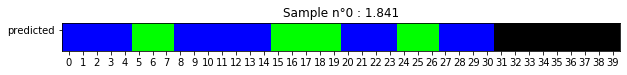

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.595857975534388
            Iterations: 201
            Function evaluations: 1240
            Gradient evaluations: 201
2.3203628063201904


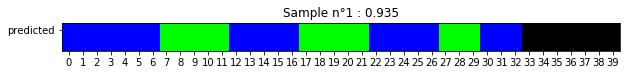

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.587368503294734
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.709869384765625


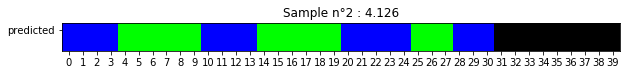

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.591257813756378
            Iterations: 201
            Function evaluations: 1185
            Gradient evaluations: 201
2.2361223697662354


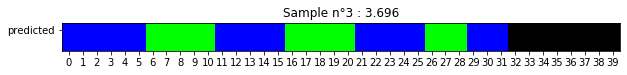

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.309505839328558
            Iterations: 201
            Function evaluations: 1337
            Gradient evaluations: 201
2.1591618061065674


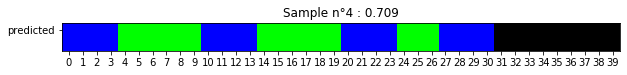

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.783591978964733
            Iterations: 201
            Function evaluations: 1625
            Gradient evaluations: 201
2.242999792098999


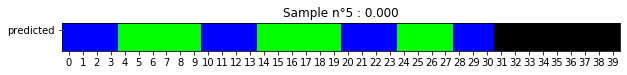

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.769589972992575
            Iterations: 201
            Function evaluations: 1419
            Gradient evaluations: 201
2.3138816356658936


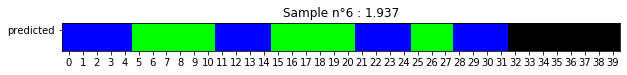

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.5268154404887895
            Iterations: 201
            Function evaluations: 575
            Gradient evaluations: 201
1.8303873538970947


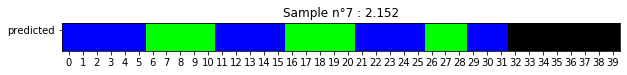

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.663922547379825
            Iterations: 201
            Function evaluations: 1141
            Gradient evaluations: 201
2.222493886947632


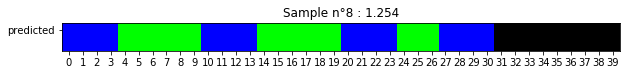

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.6549719701109655
            Iterations: 201
            Function evaluations: 1229
            Gradient evaluations: 201
2.253434419631958


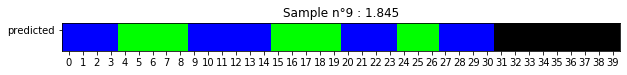

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.952852569614416
            Iterations: 201
            Function evaluations: 1580
            Gradient evaluations: 201
2.4873478412628174


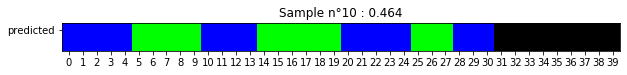

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.7284634763390985
            Iterations: 201
            Function evaluations: 1346
            Gradient evaluations: 201
2.2848262786865234


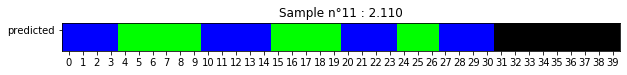

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 12.028254960639723
            Iterations: 201
            Function evaluations: 1148
            Gradient evaluations: 201
2.4275777339935303


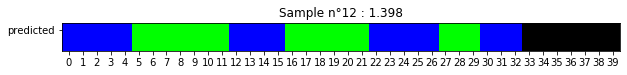

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.677446537343679
            Iterations: 201
            Function evaluations: 1274
            Gradient evaluations: 201
2.468120813369751


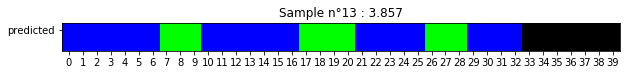

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.952596860925063
            Iterations: 201
            Function evaluations: 1373
            Gradient evaluations: 201
2.3251657485961914


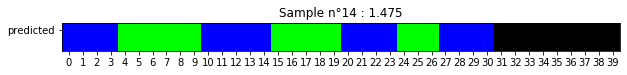

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.337665551694621
            Iterations: 201
            Function evaluations: 1409
            Gradient evaluations: 201
2.3416080474853516


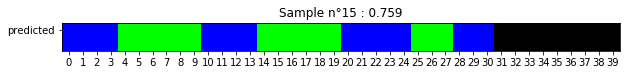

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.405212616356264
            Iterations: 201
            Function evaluations: 1185
            Gradient evaluations: 201
2.214430809020996


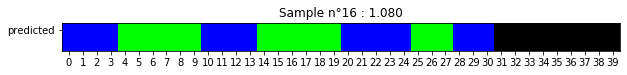

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.871353813152789
            Iterations: 201
            Function evaluations: 806
            Gradient evaluations: 201
2.276549816131592


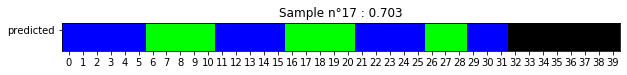

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.224133095313313
            Iterations: 201
            Function evaluations: 1004
            Gradient evaluations: 201
2.080322504043579


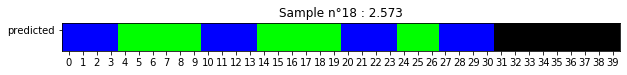

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.974456397409363
            Iterations: 201
            Function evaluations: 1004
            Gradient evaluations: 201
2.048590660095215


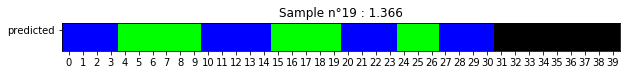

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.363710618961009
            Iterations: 201
            Function evaluations: 1382
            Gradient evaluations: 201
2.2536628246307373


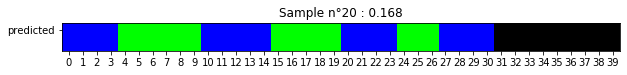

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.679597541061865
            Iterations: 201
            Function evaluations: 1544
            Gradient evaluations: 201
2.4422357082366943


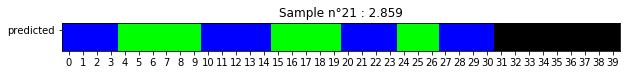

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.190595325367067
            Iterations: 201
            Function evaluations: 1303
            Gradient evaluations: 201
2.2553491592407227


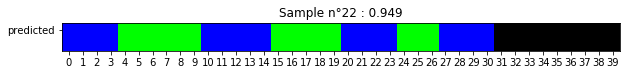

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.939996119429997
            Iterations: 201
            Function evaluations: 1625
            Gradient evaluations: 201
2.4041197299957275


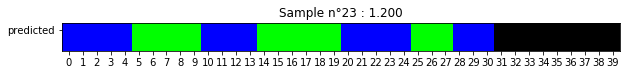

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.517430592496623
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.8828566074371338


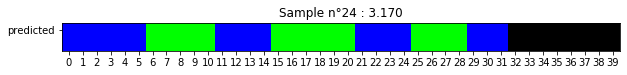

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.109599071217783
            Iterations: 201
            Function evaluations: 1589
            Gradient evaluations: 201
2.1447198390960693


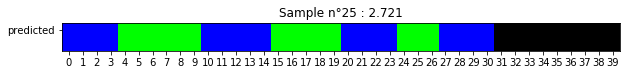

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.152151630400554
            Iterations: 201
            Function evaluations: 1175
            Gradient evaluations: 201
1.958261251449585


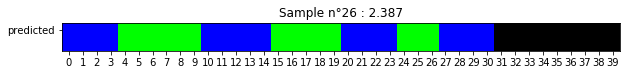

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.578149509861784
            Iterations: 201
            Function evaluations: 446
            Gradient evaluations: 201
1.8236958980560303


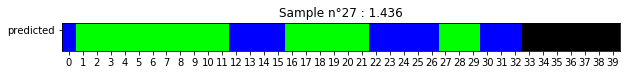

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.468124550398665
            Iterations: 201
            Function evaluations: 869
            Gradient evaluations: 201
1.6700963973999023


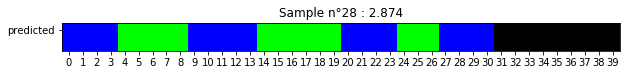

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.38854030685998
            Iterations: 201
            Function evaluations: 1122
            Gradient evaluations: 201
2.045236349105835


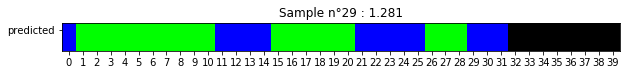

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.311781795144821
            Iterations: 201
            Function evaluations: 1411
            Gradient evaluations: 201
2.0554919242858887


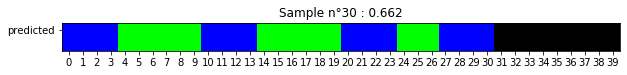

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.047828154095658
            Iterations: 201
            Function evaluations: 1103
            Gradient evaluations: 201
1.9211673736572266


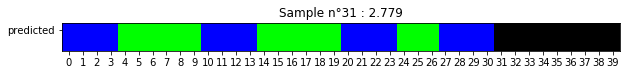

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.719364824291027
            Iterations: 201
            Function evaluations: 680
            Gradient evaluations: 201
1.707698106765747


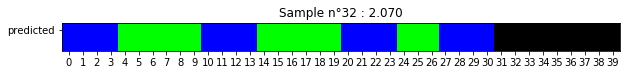

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.782366204390487
            Iterations: 201
            Function evaluations: 1184
            Gradient evaluations: 201
1.9747657775878906


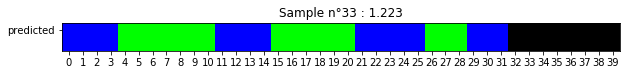

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.937160392786682
            Iterations: 201
            Function evaluations: 1364
            Gradient evaluations: 201
2.0158140659332275


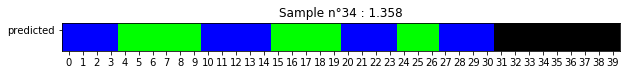

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.747923612708092
            Iterations: 201
            Function evaluations: 1601
            Gradient evaluations: 201
2.173673391342163


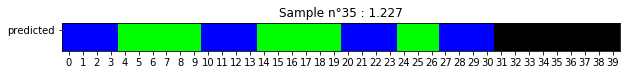

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.009505008340952
            Iterations: 201
            Function evaluations: 1166
            Gradient evaluations: 201
1.972238302230835


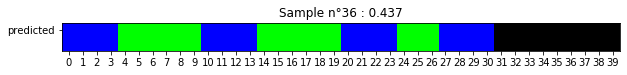

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.010466170382394
            Iterations: 201
            Function evaluations: 1482
            Gradient evaluations: 201
2.3564183712005615


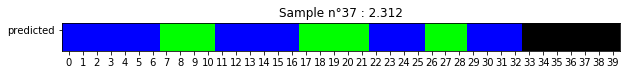

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.911476471576913
            Iterations: 201
            Function evaluations: 1571
            Gradient evaluations: 201
2.159484386444092


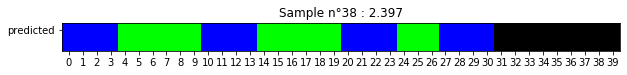

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.980392371546847
            Iterations: 201
            Function evaluations: 1598
            Gradient evaluations: 201
2.158768892288208


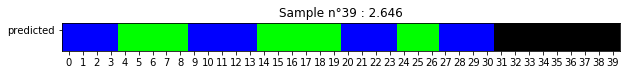

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.838838425145023
            Iterations: 201
            Function evaluations: 1580
            Gradient evaluations: 201
2.378509998321533


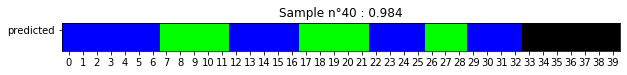

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.277323114591745
            Iterations: 201
            Function evaluations: 824
            Gradient evaluations: 201
2.0625247955322266


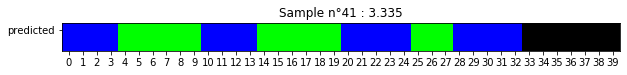

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.516391006233783
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.8386287689208984


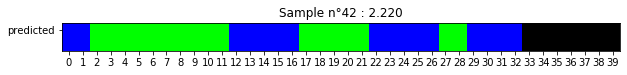

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.633882274736049
            Iterations: 201
            Function evaluations: 1122
            Gradient evaluations: 201
2.04884934425354


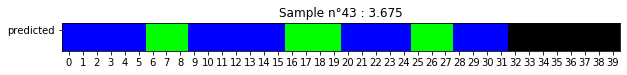

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.469379307110295
            Iterations: 201
            Function evaluations: 572
            Gradient evaluations: 201
1.8322484493255615


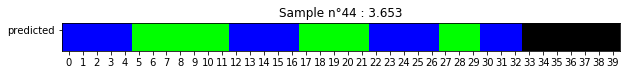

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.60172635852571
            Iterations: 201
            Function evaluations: 536
            Gradient evaluations: 201
1.8165411949157715


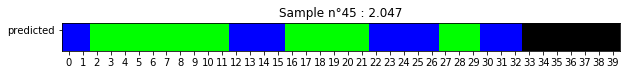

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.420798781871232
            Iterations: 201
            Function evaluations: 1526
            Gradient evaluations: 201
2.093852996826172


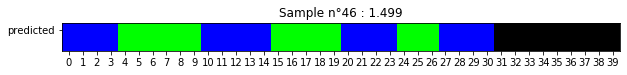

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.692610024478635
            Iterations: 201
            Function evaluations: 1114
            Gradient evaluations: 201
1.902672529220581


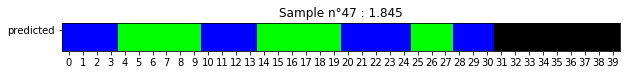

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.425974155124872
            Iterations: 201
            Function evaluations: 977
            Gradient evaluations: 201
1.8578219413757324


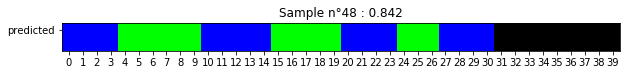

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.462492019359639
            Iterations: 201
            Function evaluations: 1499
            Gradient evaluations: 201
2.079197406768799


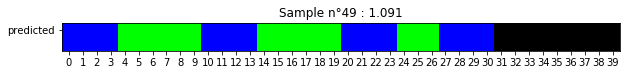

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 14.292024057825113
            Iterations: 201
            Function evaluations: 1553
            Gradient evaluations: 201
2.134028196334839


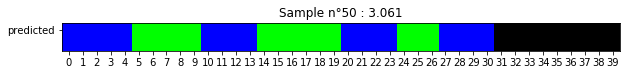

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.718945894868337
            Iterations: 201
            Function evaluations: 518
            Gradient evaluations: 201
1.9183366298675537


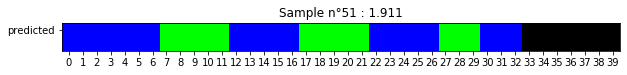

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.927406034981155
            Iterations: 201
            Function evaluations: 498
            Gradient evaluations: 201
2.006007194519043


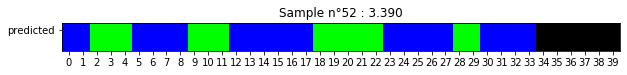

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.17751820798465
            Iterations: 201
            Function evaluations: 1607
            Gradient evaluations: 201
2.2255327701568604


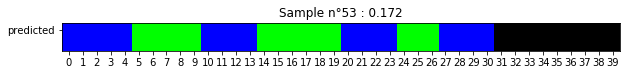

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.08567011835846
            Iterations: 201
            Function evaluations: 1347
            Gradient evaluations: 201
2.2657310962677


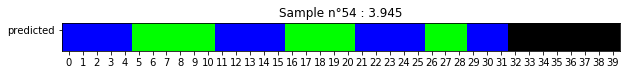

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.64729491954192
            Iterations: 201
            Function evaluations: 1337
            Gradient evaluations: 201
2.305396318435669


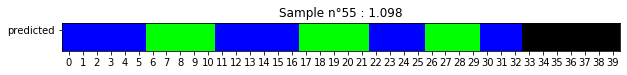

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.103409020027132
            Iterations: 201
            Function evaluations: 1499
            Gradient evaluations: 201
2.1435205936431885


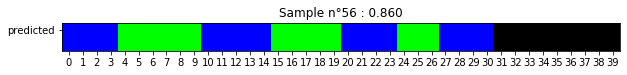

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.364648362477498
            Iterations: 201
            Function evaluations: 1175
            Gradient evaluations: 201
2.0776424407958984


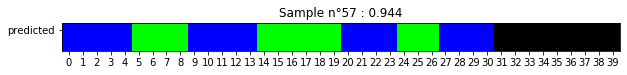

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.747237411226917
            Iterations: 201
            Function evaluations: 1076
            Gradient evaluations: 201
2.2480077743530273


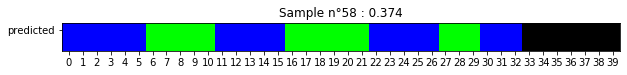

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.4714519854293995
            Iterations: 201
            Function evaluations: 1130
            Gradient evaluations: 201
2.079617500305176


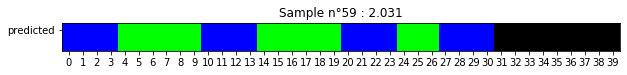

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.939305043090711
            Iterations: 201
            Function evaluations: 1418
            Gradient evaluations: 201
2.1270968914031982


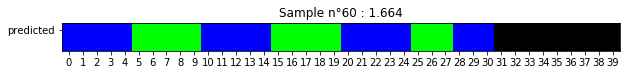

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.600932019539208
            Iterations: 201
            Function evaluations: 1193
            Gradient evaluations: 201
2.2685840129852295


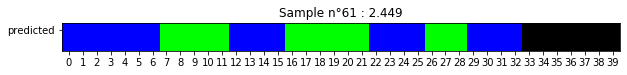

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.480672020375181
            Iterations: 201
            Function evaluations: 1454
            Gradient evaluations: 201
2.1573784351348877


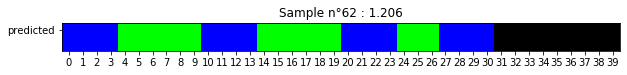

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.807353941816395
            Iterations: 201
            Function evaluations: 1157
            Gradient evaluations: 201
1.9905383586883545


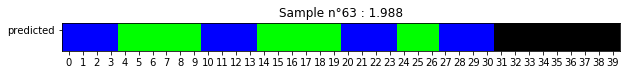

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.91850474569399
            Iterations: 201
            Function evaluations: 1517
            Gradient evaluations: 201
2.4740853309631348


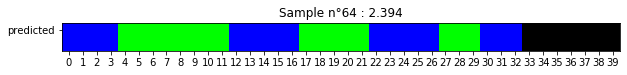

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.327546851917639
            Iterations: 201
            Function evaluations: 1059
            Gradient evaluations: 201
1.9663827419281006


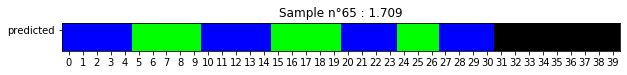

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.119436269529942
            Iterations: 201
            Function evaluations: 904
            Gradient evaluations: 200
1.9598824977874756


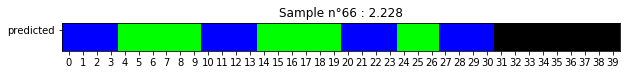

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.353894622085698
            Iterations: 201
            Function evaluations: 1140
            Gradient evaluations: 201
2.0199947357177734


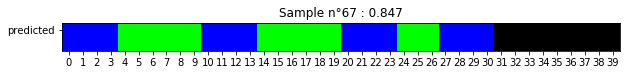

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.113130483209526
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.8331706523895264


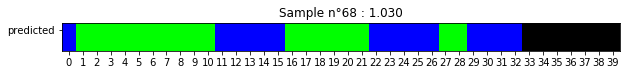

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.459527087585569
            Iterations: 201
            Function evaluations: 1284
            Gradient evaluations: 201
2.066467523574829


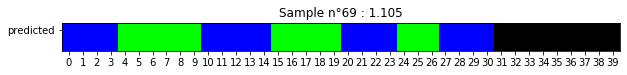

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.296457872740923
            Iterations: 201
            Function evaluations: 1292
            Gradient evaluations: 201
2.047149419784546


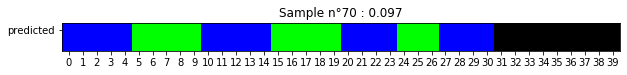

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.191553385553805
            Iterations: 201
            Function evaluations: 1445
            Gradient evaluations: 201
2.341590404510498


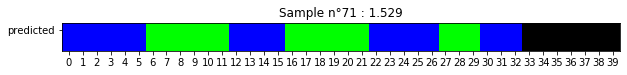

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.212424561836426
            Iterations: 201
            Function evaluations: 511
            Gradient evaluations: 201
1.4417943954467773


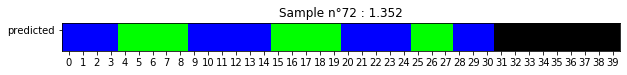

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.802284021093753
            Iterations: 201
            Function evaluations: 402
            Gradient evaluations: 201
1.6141712665557861


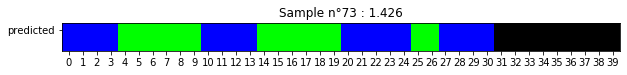

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.561545657386509
            Iterations: 201
            Function evaluations: 1374
            Gradient evaluations: 201
2.2916412353515625


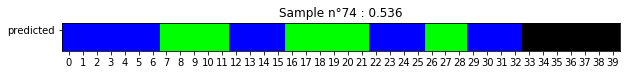

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.002943346618961
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.7196431159973145


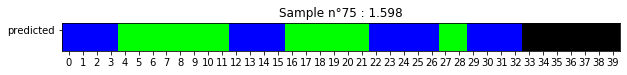

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.705618103138784
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.7460050582885742


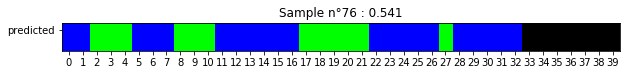

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.482442630405777
            Iterations: 201
            Function evaluations: 1472
            Gradient evaluations: 201
1.9892065525054932


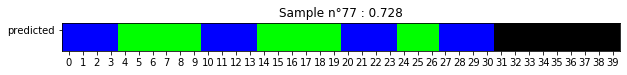

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.106906353603484
            Iterations: 201
            Function evaluations: 1418
            Gradient evaluations: 201
1.9665422439575195


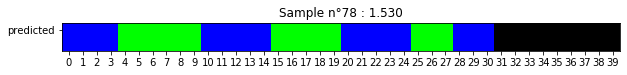

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.905262479899507
            Iterations: 201
            Function evaluations: 1292
            Gradient evaluations: 201
1.874903917312622


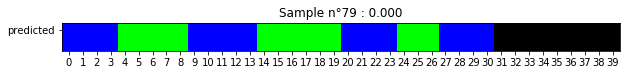

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.692584401517223
            Iterations: 201
            Function evaluations: 1051
            Gradient evaluations: 201
1.9904959201812744


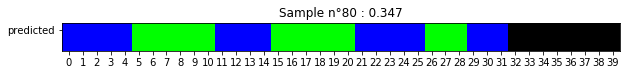

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.35977200221978
            Iterations: 201
            Function evaluations: 1571
            Gradient evaluations: 201
2.2904584407806396


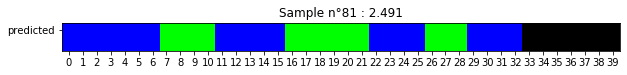

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.881649887672035
            Iterations: 201
            Function evaluations: 581
            Gradient evaluations: 201
1.6333675384521484


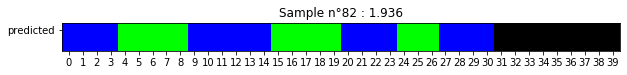

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.867855692508037
            Iterations: 201
            Function evaluations: 1148
            Gradient evaluations: 201
2.078420639038086


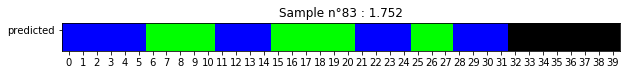

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.61306914779613
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.7219021320343018


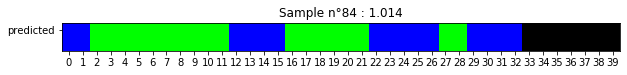

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.9557734954550465
            Iterations: 201
            Function evaluations: 1436
            Gradient evaluations: 201
2.0398552417755127


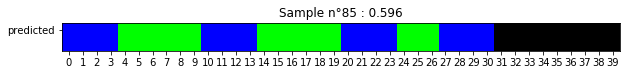

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.2506525114489895
            Iterations: 201
            Function evaluations: 1499
            Gradient evaluations: 201
2.060391426086426


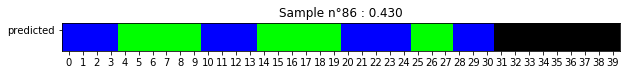

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.150669722609695
            Iterations: 201
            Function evaluations: 1067
            Gradient evaluations: 201
1.9693570137023926


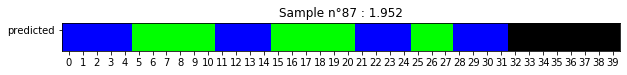

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 15.617449314501854
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.5427231788635254


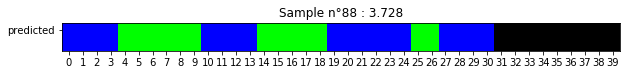

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 42.34610428599968
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.7119920253753662


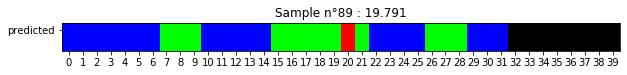

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 2.900689629045158
            Iterations: 201
            Function evaluations: 1166
            Gradient evaluations: 201
2.031895160675049


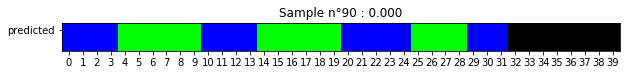

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.65194015610123
            Iterations: 201
            Function evaluations: 851
            Gradient evaluations: 201
1.7846159934997559


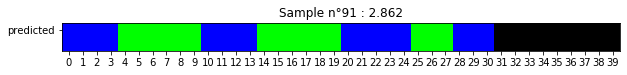

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.28238295032425
            Iterations: 201
            Function evaluations: 1346
            Gradient evaluations: 201
1.9988961219787598


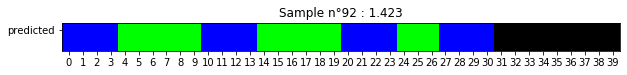

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.727607563868716
            Iterations: 201
            Function evaluations: 403
            Gradient evaluations: 201
1.949173927307129


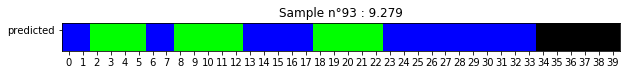

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.9297026350746975
            Iterations: 201
            Function evaluations: 1085
            Gradient evaluations: 201
1.7864625453948975


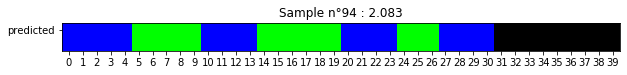

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.721768810441749
            Iterations: 201
            Function evaluations: 1229
            Gradient evaluations: 201
2.069251775741577


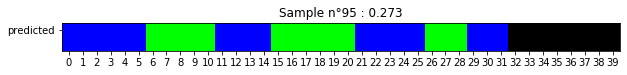

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.469786279552129
            Iterations: 201
            Function evaluations: 1184
            Gradient evaluations: 201
1.9006376266479492


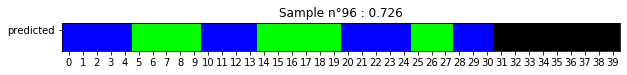

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.3732698337268685
            Iterations: 201
            Function evaluations: 887
            Gradient evaluations: 201
1.782268762588501


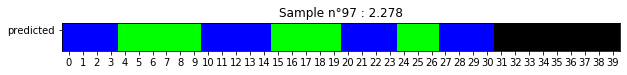

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.845370853797415
            Iterations: 201
            Function evaluations: 1157
            Gradient evaluations: 201
2.052424907684326


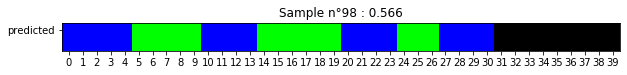

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 15.726943906055764
            Iterations: 201
            Function evaluations: 1562
            Gradient evaluations: 201
2.774770498275757


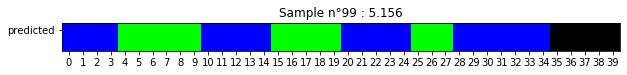

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.60721523392046
            Iterations: 201
            Function evaluations: 1643
            Gradient evaluations: 201
2.1907694339752197


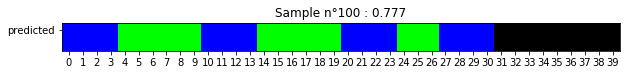

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.2791432392645214
            Iterations: 201
            Function evaluations: 1340
            Gradient evaluations: 201
2.263244390487671


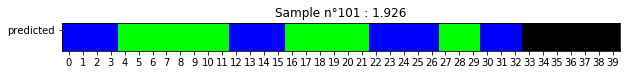

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.728905650002673
            Iterations: 201
            Function evaluations: 1544
            Gradient evaluations: 201
2.175041913986206


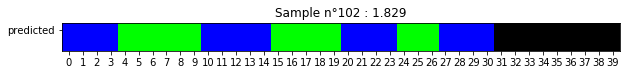

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.42127616312842
            Iterations: 201
            Function evaluations: 689
            Gradient evaluations: 201
1.7528984546661377


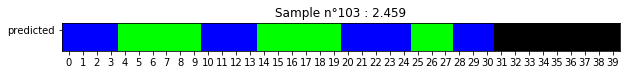

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.80503176560975
            Iterations: 201
            Function evaluations: 1391
            Gradient evaluations: 201
2.1030097007751465


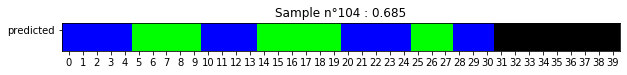

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.775350733541749
            Iterations: 201
            Function evaluations: 1329
            Gradient evaluations: 201
2.0442097187042236


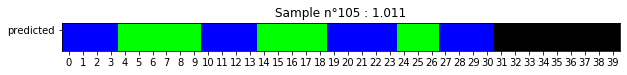

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.8323245793807486
            Iterations: 201
            Function evaluations: 1157
            Gradient evaluations: 201
1.9676060676574707


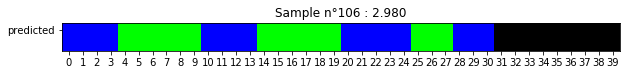

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.421780606375679
            Iterations: 201
            Function evaluations: 1013
            Gradient evaluations: 201
2.0186543464660645


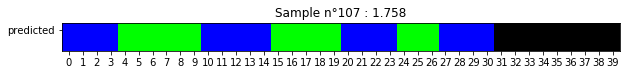

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.4335741387782255
            Iterations: 201
            Function evaluations: 1274
            Gradient evaluations: 201
2.0302340984344482


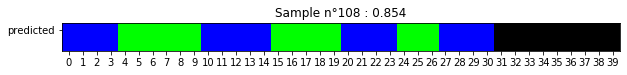

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.1989632132437205
            Iterations: 201
            Function evaluations: 1292
            Gradient evaluations: 201
1.960742473602295


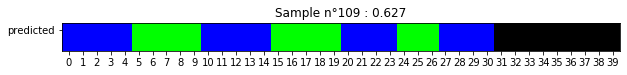

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.874195459622596
            Iterations: 201
            Function evaluations: 573
            Gradient evaluations: 201
1.6635429859161377


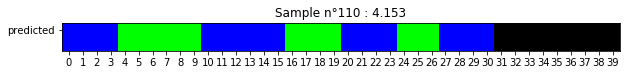

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.59071694909814
            Iterations: 201
            Function evaluations: 1463
            Gradient evaluations: 201
2.116976499557495


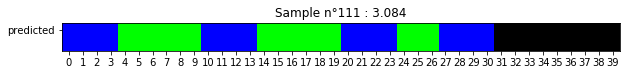

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.174464098943135
            Iterations: 201
            Function evaluations: 1445
            Gradient evaluations: 201
2.053534507751465


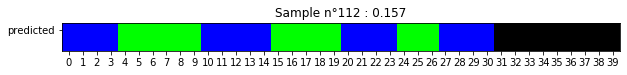

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.329864378944327
            Iterations: 201
            Function evaluations: 1517
            Gradient evaluations: 201
2.1445910930633545


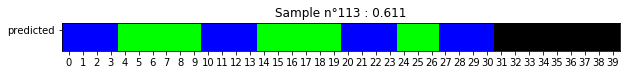

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.420673173087848
            Iterations: 201
            Function evaluations: 1463
            Gradient evaluations: 201
2.22648549079895


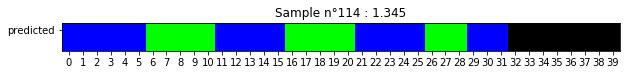

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.092598443143723
            Iterations: 201
            Function evaluations: 1625
            Gradient evaluations: 201
2.170280694961548


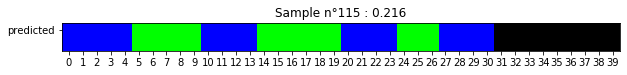

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.3643455150017
            Iterations: 201
            Function evaluations: 1544
            Gradient evaluations: 201
2.344125747680664


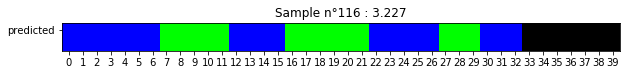

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.861788536419226
            Iterations: 201
            Function evaluations: 1490
            Gradient evaluations: 201
2.1161956787109375


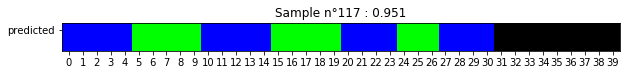

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.508278705114364
            Iterations: 201
            Function evaluations: 1490
            Gradient evaluations: 201
2.113654851913452


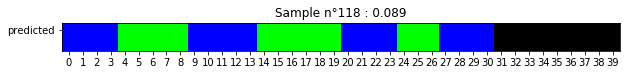

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.884098930958109
            Iterations: 201
            Function evaluations: 1328
            Gradient evaluations: 201
2.2301182746887207


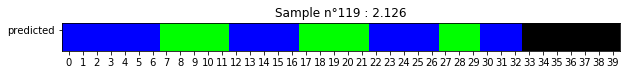

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.936945961844732
            Iterations: 201
            Function evaluations: 1643
            Gradient evaluations: 201
2.3857343196868896


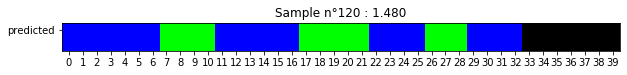

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 16.85236772704023
            Iterations: 201
            Function evaluations: 1634
            Gradient evaluations: 201
2.301331043243408


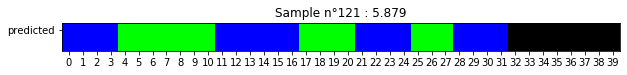

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.062265850842705
            Iterations: 201
            Function evaluations: 1400
            Gradient evaluations: 201
1.8950674533843994


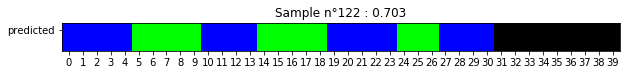

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.112644039894345
            Iterations: 201
            Function evaluations: 1580
            Gradient evaluations: 201
2.1283621788024902


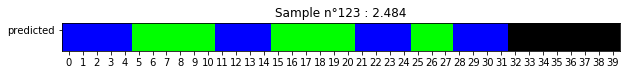

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.054323324748223
            Iterations: 201
            Function evaluations: 1139
            Gradient evaluations: 201
1.8421764373779297


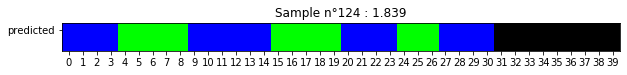

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.339237710031993
            Iterations: 201
            Function evaluations: 1382
            Gradient evaluations: 201
1.9506103992462158


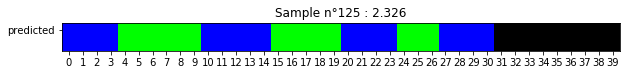

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 14.44154114922977
            Iterations: 201
            Function evaluations: 410
            Gradient evaluations: 201
1.6180977821350098


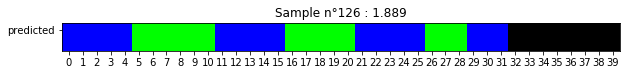

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.33489623207297
            Iterations: 201
            Function evaluations: 1706
            Gradient evaluations: 201
2.073406934738159


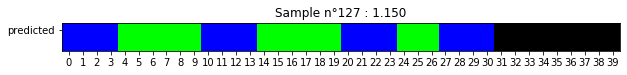

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.886078117504336
            Iterations: 201
            Function evaluations: 1068
            Gradient evaluations: 201
1.7496216297149658


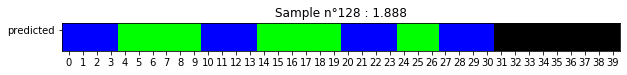

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.199958890969188
            Iterations: 201
            Function evaluations: 1015
            Gradient evaluations: 201
1.7886335849761963


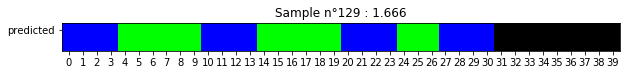

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.73549341210822
            Iterations: 201
            Function evaluations: 419
            Gradient evaluations: 201
1.7370049953460693


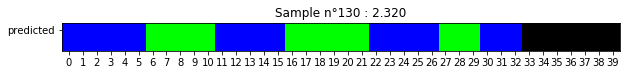

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.0920313765237815
            Iterations: 201
            Function evaluations: 1347
            Gradient evaluations: 201
2.0569279193878174


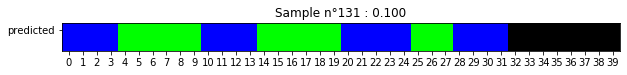

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.229006650797912
            Iterations: 201
            Function evaluations: 1355
            Gradient evaluations: 201
1.8567955493927002


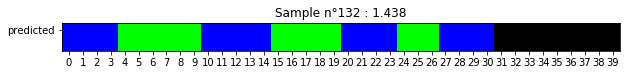

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.890098030735429
            Iterations: 201
            Function evaluations: 1544
            Gradient evaluations: 201
1.9642596244812012


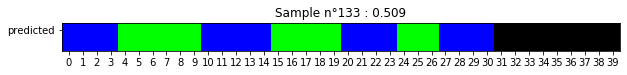

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.273472443466741
            Iterations: 201
            Function evaluations: 863
            Gradient evaluations: 201
1.830895185470581


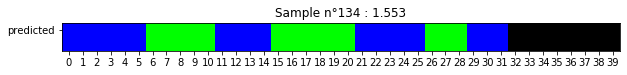

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.637515554428429
            Iterations: 201
            Function evaluations: 1023
            Gradient evaluations: 201
1.7944672107696533


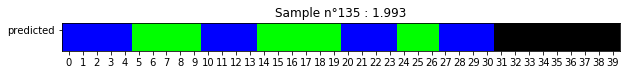

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.780841060803342
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.4914305210113525


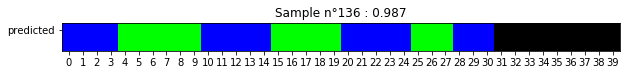

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 18.080965442429164
            Iterations: 201
            Function evaluations: 496
            Gradient evaluations: 201
1.5743095874786377


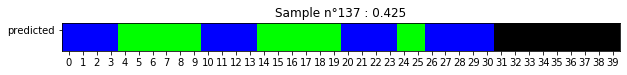

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.80534931534982
            Iterations: 201
            Function evaluations: 1490
            Gradient evaluations: 201
1.9672398567199707


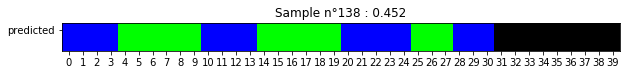

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.322460490785689
            Iterations: 201
            Function evaluations: 1283
            Gradient evaluations: 201
1.8870258331298828


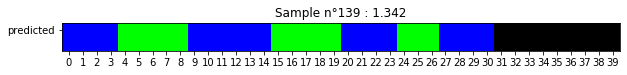

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.733905427852685
            Iterations: 201
            Function evaluations: 1113
            Gradient evaluations: 201
1.816854476928711


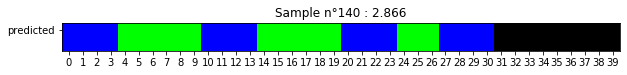

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.699497524938279
            Iterations: 201
            Function evaluations: 555
            Gradient evaluations: 201
1.7719159126281738


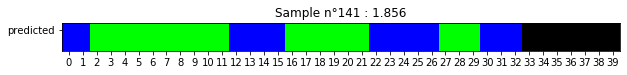

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 15.994459205280524
            Iterations: 201
            Function evaluations: 412
            Gradient evaluations: 201
1.746535301208496


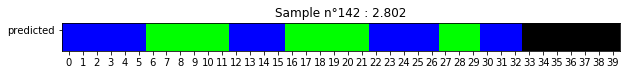

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.682128156906174
            Iterations: 201
            Function evaluations: 1706
            Gradient evaluations: 201
2.0714051723480225


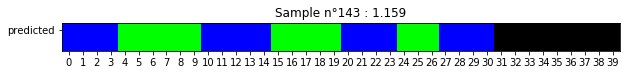

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.495490994877791
            Iterations: 201
            Function evaluations: 1310
            Gradient evaluations: 201
1.8837878704071045


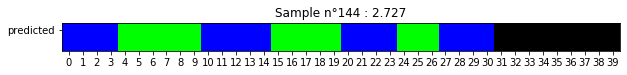

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.599199378246711
            Iterations: 201
            Function evaluations: 1391
            Gradient evaluations: 201
1.921154499053955


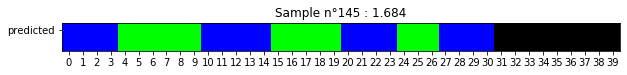

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.11458089244828
            Iterations: 201
            Function evaluations: 1589
            Gradient evaluations: 201
2.040651798248291


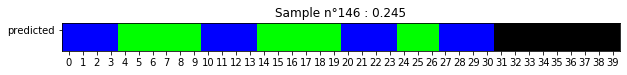

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.106747222413437
            Iterations: 201
            Function evaluations: 1436
            Gradient evaluations: 201
2.0869386196136475


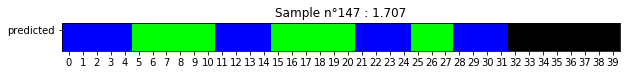

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.985964828393627
            Iterations: 201
            Function evaluations: 1625
            Gradient evaluations: 201
2.372481107711792


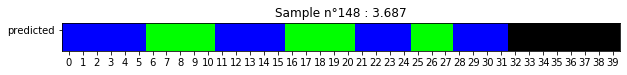

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.34104329807999
            Iterations: 201
            Function evaluations: 1221
            Gradient evaluations: 201
1.9363582134246826


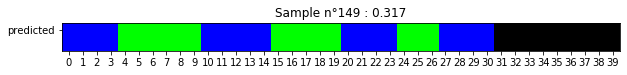

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 25.19092912409909
            Iterations: 201
            Function evaluations: 403
            Gradient evaluations: 201
1.7260277271270752


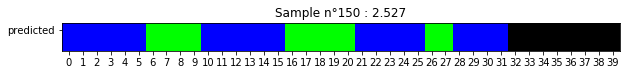

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.785768844738739
            Iterations: 201
            Function evaluations: 1463
            Gradient evaluations: 201
2.1762919425964355


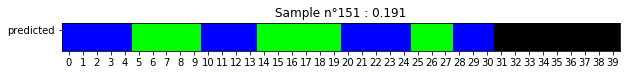

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.65247211916573
            Iterations: 201
            Function evaluations: 1670
            Gradient evaluations: 201
2.3712313175201416


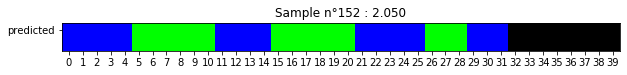

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.087912124041488
            Iterations: 201
            Function evaluations: 1148
            Gradient evaluations: 201
1.9785196781158447


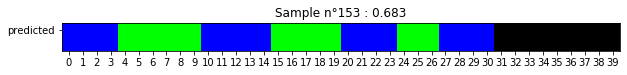

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.714979051730424
            Iterations: 201
            Function evaluations: 1391
            Gradient evaluations: 201
2.0603084564208984


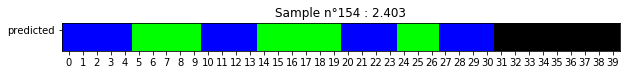

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.101301736095707
            Iterations: 201
            Function evaluations: 1042
            Gradient evaluations: 201
1.9816830158233643


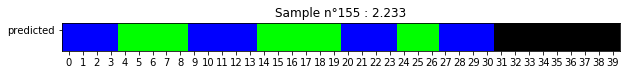

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.443191878625975
            Iterations: 201
            Function evaluations: 1679
            Gradient evaluations: 201
2.201374053955078


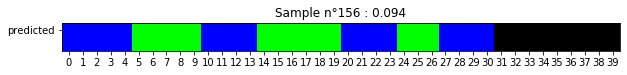

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.469649860105637
            Iterations: 201
            Function evaluations: 1616
            Gradient evaluations: 201
2.2053630352020264


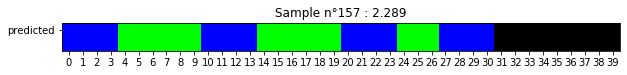

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.734771946682716
            Iterations: 201
            Function evaluations: 1400
            Gradient evaluations: 201
2.0772979259490967


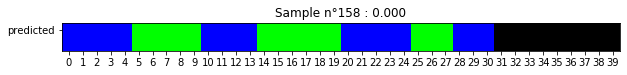

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.231912079697569
            Iterations: 201
            Function evaluations: 1598
            Gradient evaluations: 201
2.178187370300293


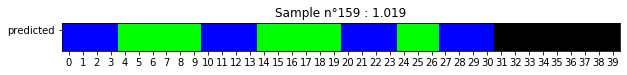

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.400247485843471
            Iterations: 201
            Function evaluations: 1419
            Gradient evaluations: 201
2.0477676391601562


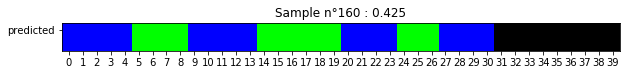

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.794466287101548
            Iterations: 201
            Function evaluations: 1409
            Gradient evaluations: 201
2.0890586376190186


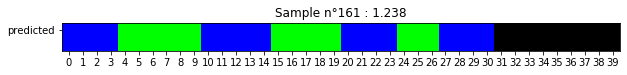

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.189267894350792
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.7708895206451416


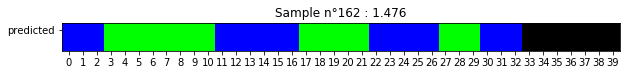

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.566494730528914
            Iterations: 201
            Function evaluations: 1436
            Gradient evaluations: 201
2.101732015609741


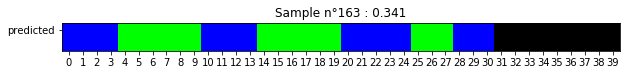

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.29749770527052
            Iterations: 201
            Function evaluations: 1049
            Gradient evaluations: 201
1.8647665977478027


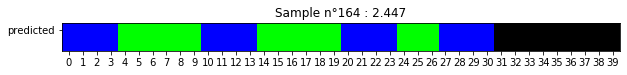

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.57918638598418
            Iterations: 201
            Function evaluations: 1346
            Gradient evaluations: 201
2.4379794597625732


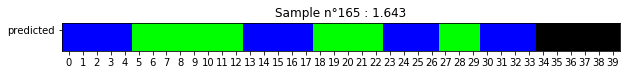

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.134779332276521
            Iterations: 201
            Function evaluations: 1256
            Gradient evaluations: 201
2.0080487728118896


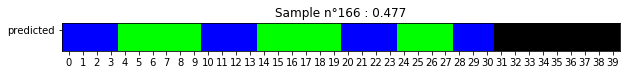

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.159287279488624
            Iterations: 201
            Function evaluations: 1391
            Gradient evaluations: 201
2.4994726181030273


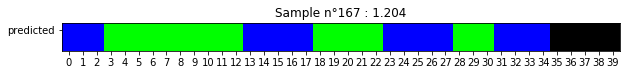

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.599514438973516
            Iterations: 201
            Function evaluations: 771
            Gradient evaluations: 201
1.8772845268249512


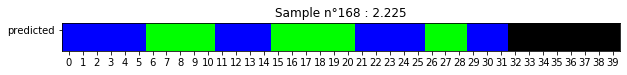

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.239026073328033
            Iterations: 201
            Function evaluations: 1186
            Gradient evaluations: 201
1.9466400146484375


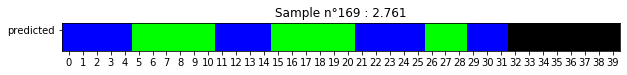

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 3.588984302848992
            Iterations: 201
            Function evaluations: 1229
            Gradient evaluations: 201
1.9364380836486816


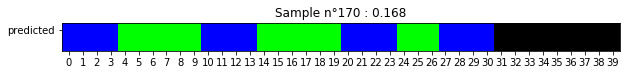

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 4.790673580340433
            Iterations: 201
            Function evaluations: 941
            Gradient evaluations: 201
1.643003225326538


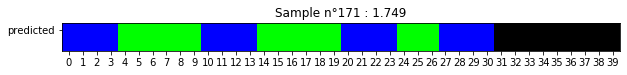

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.165604170014687
            Iterations: 201
            Function evaluations: 1580
            Gradient evaluations: 201
2.0681333541870117


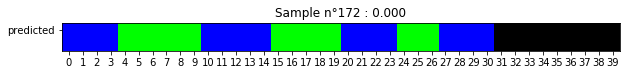

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.58213050257396
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.5242722034454346


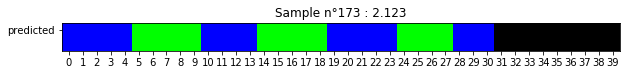

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.41929004076327
            Iterations: 201
            Function evaluations: 1067
            Gradient evaluations: 201
1.8004896640777588


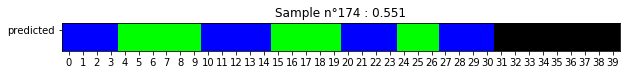

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.983009619389582
            Iterations: 201
            Function evaluations: 689
            Gradient evaluations: 201
1.6485168933868408


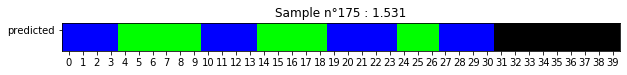

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.700271373759864
            Iterations: 201
            Function evaluations: 1373
            Gradient evaluations: 201
2.0956642627716064


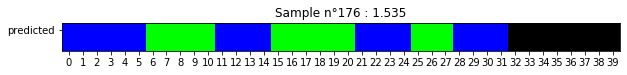

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.306731771911394
            Iterations: 201
            Function evaluations: 1508
            Gradient evaluations: 201
2.0178792476654053


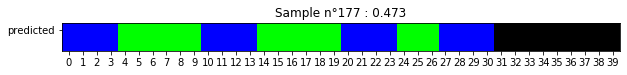

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.716278911453038
            Iterations: 201
            Function evaluations: 1652
            Gradient evaluations: 201
2.143893241882324


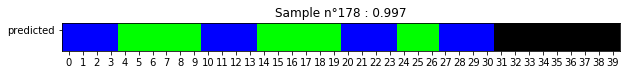

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.762410783532632
            Iterations: 201
            Function evaluations: 402
            Gradient evaluations: 201
1.529867172241211


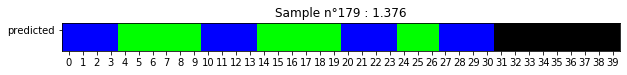

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.055939900778959
            Iterations: 201
            Function evaluations: 1490
            Gradient evaluations: 201
2.065486431121826


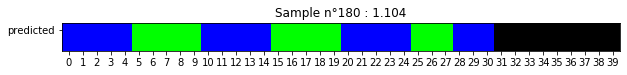

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.097548431958433
            Iterations: 201
            Function evaluations: 1521
            Gradient evaluations: 201
2.008087396621704


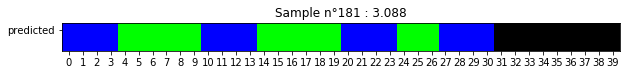

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.399891169337588
            Iterations: 201
            Function evaluations: 1481
            Gradient evaluations: 201
1.937091588973999


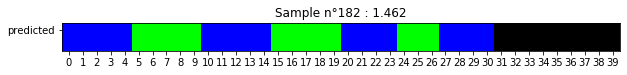

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.944930351451637
            Iterations: 201
            Function evaluations: 401
            Gradient evaluations: 201
1.712120771408081


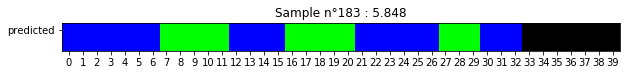

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.282272414873118
            Iterations: 201
            Function evaluations: 1706
            Gradient evaluations: 201
2.084364891052246


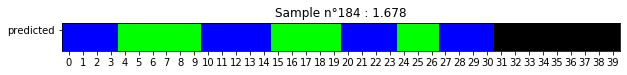

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.359137618969378
            Iterations: 201
            Function evaluations: 609
            Gradient evaluations: 201
1.7690718173980713


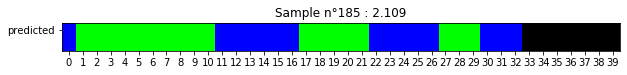

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.200718739873823
            Iterations: 201
            Function evaluations: 1338
            Gradient evaluations: 201
2.0681345462799072


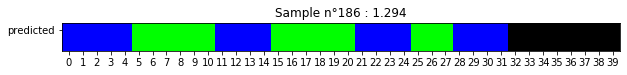

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 11.112648215933074
            Iterations: 201
            Function evaluations: 1625
            Gradient evaluations: 201
2.0262999534606934


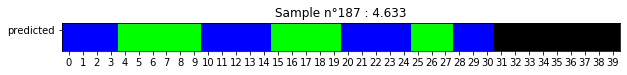

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.558363231843837
            Iterations: 201
            Function evaluations: 1553
            Gradient evaluations: 201
2.016390323638916


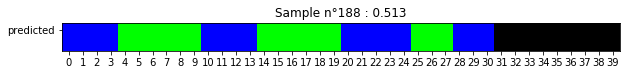

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.017374149173651
            Iterations: 201
            Function evaluations: 1418
            Gradient evaluations: 201
1.9057223796844482


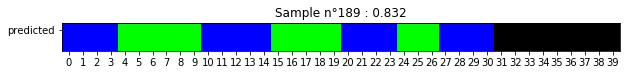

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.107063377280847
            Iterations: 201
            Function evaluations: 699
            Gradient evaluations: 201
1.75799560546875


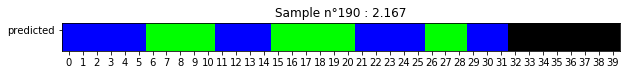

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.573393662293947
            Iterations: 201
            Function evaluations: 1347
            Gradient evaluations: 201
2.0351760387420654


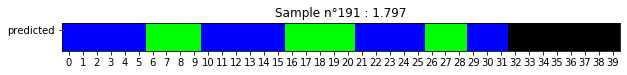

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 10.876995052514847
            Iterations: 201
            Function evaluations: 1652
            Gradient evaluations: 201
2.0826311111450195


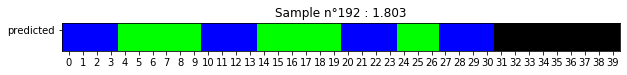

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.915984871031023
            Iterations: 201
            Function evaluations: 1482
            Gradient evaluations: 201
2.0075058937072754


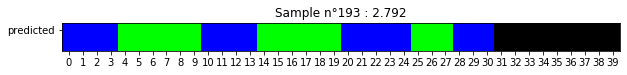

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 8.306807372408686
            Iterations: 201
            Function evaluations: 977
            Gradient evaluations: 201
1.8426871299743652


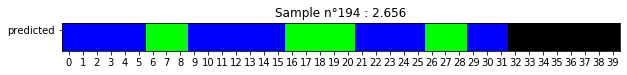

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.636036793383143
            Iterations: 201
            Function evaluations: 1103
            Gradient evaluations: 201
1.8866856098175049


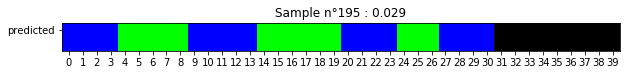

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 6.3170260307
            Iterations: 201
            Function evaluations: 1283
            Gradient evaluations: 201
2.0913870334625244


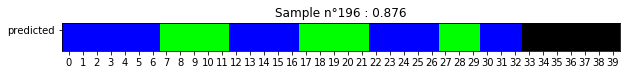

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 7.855630881761368
            Iterations: 201
            Function evaluations: 1445
            Gradient evaluations: 201
1.9466445446014404


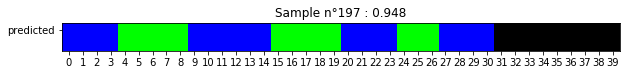

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 9.449369637880704
            Iterations: 201
            Function evaluations: 977
            Gradient evaluations: 201
1.9763879776000977


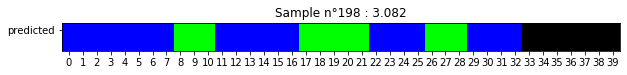

<Figure size 720x216 with 0 Axes>

Iteration limit exceeded    (Exit mode 9)
            Current function value: 5.59334871597524
            Iterations: 201
            Function evaluations: 1103
            Gradient evaluations: 201
1.804755687713623


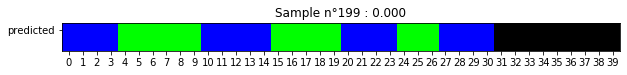

<Figure size 720x216 with 0 Axes>

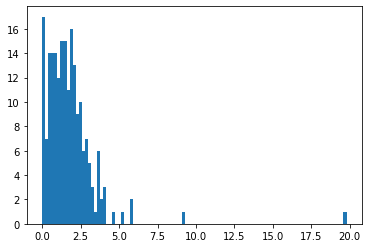

In [15]:
for i in range(200):
#     gt = np.array(val_dataset[i][2][:,-1],dtype=int)
    N = potentials[i].shape[0]
    C = potentials[i].flatten()
    constraints = sumto1[:N]+[mu_0, mu_1to2, mu_2to1, old_mu_2to1, old_mu_1to2]
    bounds = Bounds([0.]*(3*N),[1.]*(3*N))
    start = time.time()
    res = minimize(cost, potentials[i].flatten(), 
                   method ='SLSQP',
#                    method='L-BFGS-B', 
#                    method ='trust-constr',
                   jac=jac, 
         constraints = constraints, 
         options={'disp': True, 'maxiter':200, 'sparse_jacobian':True},
         bounds = bounds
        )
    print(time.time()-start)
    p = res.x[:3*N].reshape(N,3).argmax(1)
    gt = np.argmax(potentials[i],1)
    negll = cost(to_onehot(p, (None,3)).flatten()+1e-8)-cost(to_onehot(gt, (None,3)).flatten()+1e-8)
    costs.append(negll)
    q, r = N//SIZE, N%SIZE
    for j in range(q):
        fig = plt.figure(figsize=(10,3))
        mapping_pred = to_onehot(p[SIZE*j:SIZE*(j+1)], (None,3)).reshape((SIZE,3))
#         mapping_true = o_onehot(gt[SIZE*j:SIZE*(j+1)], (None,3)).reshape((SIZE,3))
        mapping = np.array([mapping_pred,mapping_pred])
        plt.xticks(list(range(0,SIZE,20)), list(range(SIZE*j,SIZE*(j+1),20)))
        plt.yticks([0,1],["ground truth", "predicted"])
        plt.imshow(mapping)

    fig = plt.figure(figsize=(10,3))
    mapping_pred = np.pad(to_onehot(p[-r:], (None,3)),((0,SIZE-r),(0,0))).reshape((SIZE,3))
#     mapping_true = np.pad(to_onehot(gt[-r:], (None,3)),((0,SIZE-r),(0,0))).reshape((SIZE,3))
    mapping = np.array([mapping_pred,mapping_pred])
    plt.xticks(list(range(0,SIZE,1)), list(range(SIZE*q,SIZE*(q+1),1)))
    plt.yticks([0],["predicted"])
    plt.title(f"Sample n°{i} : {negll:.3f}")
    plt.imshow(mapping)
    fig = plt.figure(figsize=(10,3))
    plt.show()
plt.hist(costs, bins = 100)
plt.show()

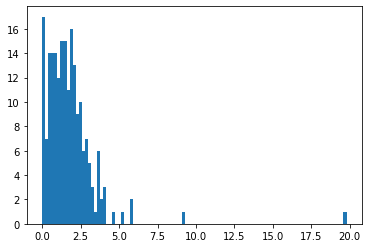

In [16]:
plt.hist(costs, bins = 100)
plt.show()

In [2]:
DATA = "/home/cyril/Documents/These/data/secondary_structure"
all_seqs = {k:np.argmax(v[0][:,:20],1) for k,v in pickle.load(open(f"{DATA}/full_set","rb")).items()}

In [6]:
DATA = "/home/cyril/Documents/These/data/luciferase"
lux_seqs = pickle.load(open(f"{DATA}/raw_seqs.pkl","rb"))
lux_seqs = [np.array(x) for x in lux_seqs]

In [ ]:
pickle.load(open(f"{DATA}/full_set","rb"))

## HMM

In [3]:
Q,T,pi = pickle.load(open(f"{DATA}/secondary_structure/statistics.pkl", "rb"))

In [4]:
# n_patterns = [[2, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 1, 2,
#         1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2]]
# c_patterns = ["".join(["abc"[x] for x in n_patterns[0]])]

n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))

regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])

In [10]:
# data = {"".join(k.split("_")[2:]):v for k, v in pickle.load(open(f"{DATA}/{DATASET}/ss3.pkl","rb")).items()}
data = list(pickle.load(open(f"{DATA}/{DATASET}/ss3.pkl","rb")))

MAX_SIZE = 400
matchers = [PatternMatching(pattern = regex, 
                            Q = torch.zeros(Q.shape), T = T, pi = pi,
                            name = name) for regex, name in zip(regexes, c_patterns)][:1]

# matchers = [NoPatternMatching(MAX_SIZE)]

In [7]:
indices = [0]+list(np.random.choice(len(data), 9999))

In [11]:
all_costs = []
all_costs2 = []
all_transitions = []
SIZE = 64

for i, matcher in enumerate(matchers):
#     sleep(1)
    costs = []
    costs2 = []
    transitions = []
    len_pat = len(matcher.pattern)
    for j, s in tqdm(enumerate(range(len(data)))):
#         print(f"Step {i}/{len(matchers)} : [{int(100*j/len(data))}%]", end="\r")
        start = time()
        sample = torch.tensor(data[s])
        N = sample.shape[0]
        p, ll, a, b, P ,Q = matcher.match(sample)
        time_ms = int((time()-start)*1000)
        t= a[:-1].view(len_pat,-1,1)+b[1:].view(len_pat,1,-1)+P[0, matcher.pattern]+Q[0, matcher.pattern]-a[-1,-1]
        costs2.append((ll,a[-1,-1]))
        
        tr = []
        for i in range(20):
            tr.append(np.trace(torch.exp(t).numpy(), offset = i, axis1 = 1, axis2 = 2))
        tr = np.array(tr).T
        transitions.append(tr)

#         p = []
#         for i in range(transition.size(1)-1):
#             p.append(torch.exp(transition[:,:i+1,i+1:]).sum(2).sum(1).view(-1, 1))
#         p = torch.cat(p,1)

#         q = []
#         for j in range(3):
#             idx = torch.where(torch.tensor(matcher.pattern) == j)
#             q.append(p[idx].sum(0).view(-1,1))
#         q=torch.cat(q,1)
#         costs.append(q)
#         if i == 0:
#             costs.append((k,k[0],df.loc[k].folding,-ll.item(), df.loc[k].mean_id))
#         else:
#             a,b,c,d,e = costs[j]
#             d = min(d, -ll.item())
#             costs[j] = (a,b,c,d,e)
#         visualize_secondary_structure(np.array(["abc"[x] for x in p]), 0, 100)
#         plt.title(f"Sample {j} : {ll:.3f} ({time_ms} ms)")
    all_costs.append(costs)
    all_costs2.append(costs2)
    all_transitions.append(transitions)


0it [00:00, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (31) at non-singleton dimension 1

In [10]:
pickle.dump(costs2, open(f"{DATA}/{DATASET}/costs.pkl", "wb"))

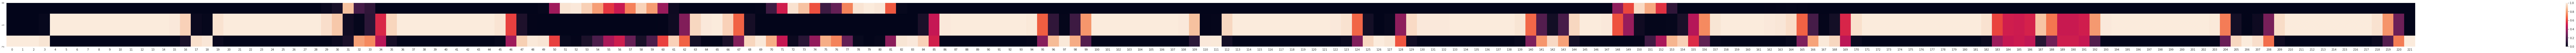

In [120]:
plt.figure(figsize = (40,7))
sns.heatmap(torch.exp(ll - torch.logsumexp(ll,1).view(-1,1)))
plt.show()

### PF00296

In [13]:
all_costs = np.array([[a[1] for a in b] for b in all_costs2])

In [17]:
all_costs.shape

(25, 100)

In [19]:
norm_costs = ((all_costs.T-all_costs.mean(1))/all_costs.std(1)).T

In [22]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA()
X = pca.fit_transform(norm_costs)

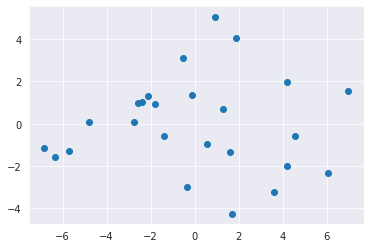

In [41]:
plt.scatter(X[:,0], X[:,1])

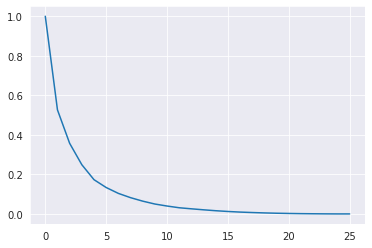

In [39]:
plt.plot([1]+list(1-pca.explained_variance_ratio_.cumsum()))
plt.show()

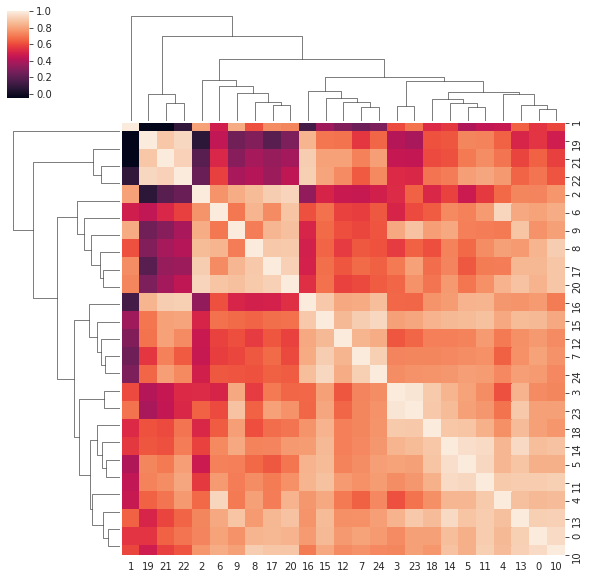

In [21]:
sns.clustermap(np.corrcoef(norm_costs))

### PF01353

In [100]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, BayesianRidge
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
from scipy.spatial.distance import cosine

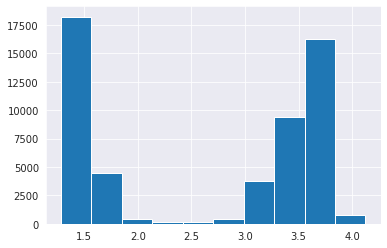

In [9]:
df = pd.read_csv(f"{DATA}/{DATASET}/amino_acid_genotypes_to_brightness.tsv", sep = "\t")
plt.hist(df.medianBrightness)
plt.show()
df = df.iloc[indices].reset_index()

In [11]:
hmms = pickle.load(open(f"{DATA}/{DATASET}/hmm_spec.pkl","rb"))
hmms = [hmm[:,:20] for i,hmm in enumerate(hmms.values()) if i in indices]

In [48]:
costs2[0]

(tensor([[-37.8379,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
         [    -inf, -50.9014, -49.8310,  ...,     -inf,     -inf,     -inf],
         [    -inf,     -inf, -50.9202,  ...,     -inf,     -inf,     -inf],
         ...,
         [    -inf,     -inf,     -inf,  ..., -43.1582,     -inf,     -inf],
         [    -inf,     -inf,     -inf,  ..., -39.2805, -40.7095,     -inf],
         [    -inf,     -inf,     -inf,  ...,     -inf,     -inf, -37.8379]]),
 tensor(-37.8379))

In [64]:
t0 = transitions[0]
log_t0 = np.log(t0+1e-8)

# t0 = torch.exp(costs2[0][0]-costs2[0][1])
# log_t0 = costs2[0][0]-costs2[0][1]

low_bright = df[df.medianBrightness<2]
high_bright = df[df.medianBrightness>3]

# low_bright_costs = [costs2[i][1] for i in list(low_bright.index) if costs2[i][0].size(-1) == N]
# high_bright_costs = [costs2[i][1] for i in list(high_bright.index) if costs2[i][0].size(-1) == N]
# costs = low_bright_costs+high_bright_costs

low_bright_costs = np.array([(t0 * (log_t0 - np.log(transitions[i]+1e-8))).sum(1) for i in list(low_bright.index)])
high_bright_costs = np.array([(t0 * (log_t0 - np.log(transitions[i]+1e-8))).sum(1) for i in list(high_bright.index)])
bright_costs = [(t0 * (log_t0 - np.log(t+1e-8))).sum(1) for t in transitions]

# low_bright_costs = np.array([np.nan_to_num((c0*(c-c_0-costs2[i][0]+costs2[i][1])).numpy()).sum(1) for i in list(low_bright.index) if costs2[i][0].size(-1) == N])
# high_bright_costs = np.array([np.nan_to_num((torch.exp(c-c_0)*(c-c_0-costs2[i][0]+costs2[i][1])).numpy()).sum(1) for i in list(high_bright.index) if costs2[i][0].size(-1) == N])
# bright_costs = [None if x.size(-1) != N else np.nan_to_num((torch.exp(c-c_0)*(c-c_0-x+x_0)).numpy()).sum(1) for x, x_0 in costs2]

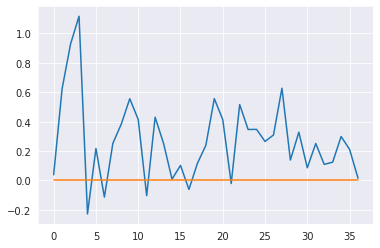

In [76]:
plt.plot(np.mean(low_bright_costs,0)/np.mean(high_bright_costs,0)-1)
plt.plot(np.mean(high_bright_costs,0)/np.mean(high_bright_costs,0)-1)
plt.show()

In [77]:
df_box = pd.DataFrame()
bright = []
pos = []
value = []
idx = []
costs = []

i=0
# for b,x in zip(df.medianBrightness,bright_costs):
#     if x is None:
#         continue
# #     p, v = np.argmax(x), np.max(x)
# #     bright.append(1)
# #     pos.append(p)
# #     value.append(v)
#     for p, v in enumerate(x):
#         bright.append(b)
#         pos.append(p)
#         value.append(v)
#         idx.append(i)
#     i+=1

for x in low_bright_costs:
    x = x
    c = costs2[i][1].item()
    for p, v in enumerate(x):
        bright.append(0)
        costs.append(c)
        pos.append(p)
        value.append(v)
        idx.append(i)
    i+=1


for x in high_bright_costs:
    x = x
    c = costs2[i][1].item()
    for p, v in enumerate(x):
        bright.append(1)
        costs.append(c)
        pos.append(p)
        value.append(v)
        idx.append(i)
    i+=1

df_box["pos"] = pos
df_box["value"] = value
df_box["bright"] = bright
df_box["idx"] = idx
df_box["costs"] = costs
costs = df_box.groupby("idx").max()["costs"].values

df_box["rank"] = 0
for i in range(bright_costs[0].shape[0]):
    rank = df_box[df_box.pos == i].sort_values("value", ascending = False)
    rank = pd.Series(range(len(rank)), rank.index)
    df_box["rank"][df_box.pos == i] = rank
    
df_box

pos     value  bright   idx      costs  rank
0         0  8.931984       0     0 -37.837906  1569
1         1  0.295136       0     0 -37.837906  2174
2         2  0.011241       0     0 -37.837906  4177
3         3  0.082916       0     0 -37.837906  3952
4         4  0.031734       0     0 -37.837906   813
...     ...       ...     ...   ...        ...   ...
363409   32  6.934044       1  9821 -35.277370   768
363410   33  2.173277       1  9821 -35.277370  1336
363411   34  0.724412       1  9821 -35.277370  5300
363412   35  0.624506       1  9821 -35.277370  4199
363413   36  7.889721       1  9821 -35.277370   989

[363414 rows x 6 columns]

In [153]:
m,n = len(df_box)//37, 37
X = np.zeros((m, n*2))
for x in df_box.itertuples():
    X[x.idx, x.pos] = x.value; X[x.idx, n+x.pos] = x.rank
    
scaler = StandardScaler()
X_n = scaler.fit_transform(X)

y = df_box.groupby("idx").min().bright.values
# y = (y - y.mean())/y.std()

In [34]:
hmms = pickle.load(open(f"{DATA}/{DATASET}/hmm_spec.pkl","rb"))
hmms = [hmm for i,hmm in enumerate(hmms.values()) if i in indices]

cos_sim = np.array([cosine(hmm[:,:20].flatten(), hmm[:,20:40].flatten()) for hmm in hmms])
del hmms

cos_sim = (cos_sim - cos_sim.mean())/cos_sim.std()
cos_sim = cos_sim[indices]
cos_sim = np.array(list(cos_sim[list(low_bright.index)])+list(cos_sim[list(high_bright.index)]))

In [112]:
reducter = PCA(5)
X_n = reducter.fit_transform(X_n)

In [155]:
n_feats = 37
plt.figure(figsize = (4*n_feats,4*n_feats))
sample = X_n[np.random.choice(X.shape[0], 100)]
for i in range(n_feats):
    for j in range(n_feats):
        ax = plt.subplot(n_feats,n_feats, n_feats*i+j+1)
        plt.scatter(X_n[:,j], X_n[:,i])
plt.show()

0.7124821828548157
0.7025045815516188
0.7216452860924455
0.7187945428629607
0.7267358990022399
0.7175727957646101
0.679902260232132
0.6949704744451232
0.7497454693545103
0.6835675015271838
0.7358990022398697
0.7289757686825494
0.7187945428629607
0.6896762370189371
0.7139075544695581
0.7010792099368764
0.713093056403991
0.7159437996334759
0.718590918346569
0.6911016086336795
0.718590918346569
0.7122785583384239
0.7049480757483201
0.7332518835267766
0.7126858073712075
0.7157401751170841
0.7295866422317246
0.7202199144777031
0.7308083893300753
0.7430258603135818
0.6923233557320302
0.7371207493382204
0.7157401751170841
0.7126858073712075
0.7110568112400732
0.682549378945225
0.7210344125432702
0.7025045815516188
0.6970067196090409
0.6874363673386276
0.7039299531663612
0.6970067196090409
0.705966198330279
0.7012828344532682
0.711260435756465
0.6970067196090409
0.6941559763795561
0.7004683363877011
0.7255141519038892
0.7432294848299735
0.7084096925269803
0.7289757686825494
0.7088169415597638


KeyboardInterrupt: 

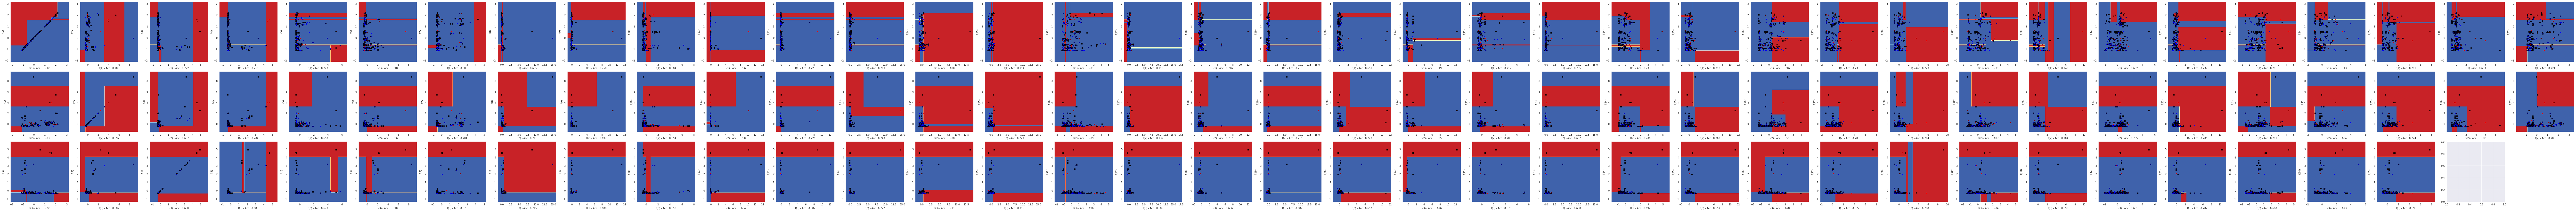

In [159]:
from itertools import product

plot_step = 0.02
plot_colors = "rb"
plt.figure(figsize=(4*n_feats,4*n_feats))
for i, pair in enumerate(product(range(n_feats), range(n_feats))):
    X_temp = X_n[:, pair]
    # Train
    clf = DecisionTreeClassifier("entropy", max_depth=4).fit(X_temp[train_index], y[train_index])

    # Plot the decision boundary
    plt.subplot(n_feats, n_feats, i + 1)

    x_min, x_max = X_temp[:, 0].min() - 1, X_temp[:, 0].max() + 1
    y_min, y_max = X_temp[:, 1].min() - 1, X_temp[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(yy, xx, Z, cmap=plt.cm.RdYlBu)

    
    for i, color in zip(range(2), plot_colors):
        idx = np.where(y[test_index] == i)
        plt.scatter(X_temp[test_index][idx, 1], X_temp[test_index][idx, 0], c=color,
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
    print(clf.score(X_temp[test_index], y[test_index]))
    plt.xlabel(f"f({pair[0]+1}) - Acc : {clf.score(X_temp[test_index], y[test_index]):.3f}")
    plt.ylabel(f"f({pair[1]+1})")


In [165]:
from sklearn.model_selection import KFold, StratifiedKFold
pred_test = np.zeros(y.shape)
skf = KFold(2, shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index,:37], X[test_index,:37]
    y_train, y_test = y[train_index], y[test_index]
#     model = MLPClassifier(early_stopping = True)
#     model = RandomForestClassifier(10, max_depth = 10)
    model = DecisionTreeClassifier("entropy", min_samples_leaf = 100)
    model = model.fit(X_train,y_train)
    pred_test[test_index] = model.predict_proba(X_test)[:,1]
#     print(spearmanr(model.predict(X_test), y_test))
    print(model.score(X_test, y_test))

0.8957442476074119
0.8692730604764813


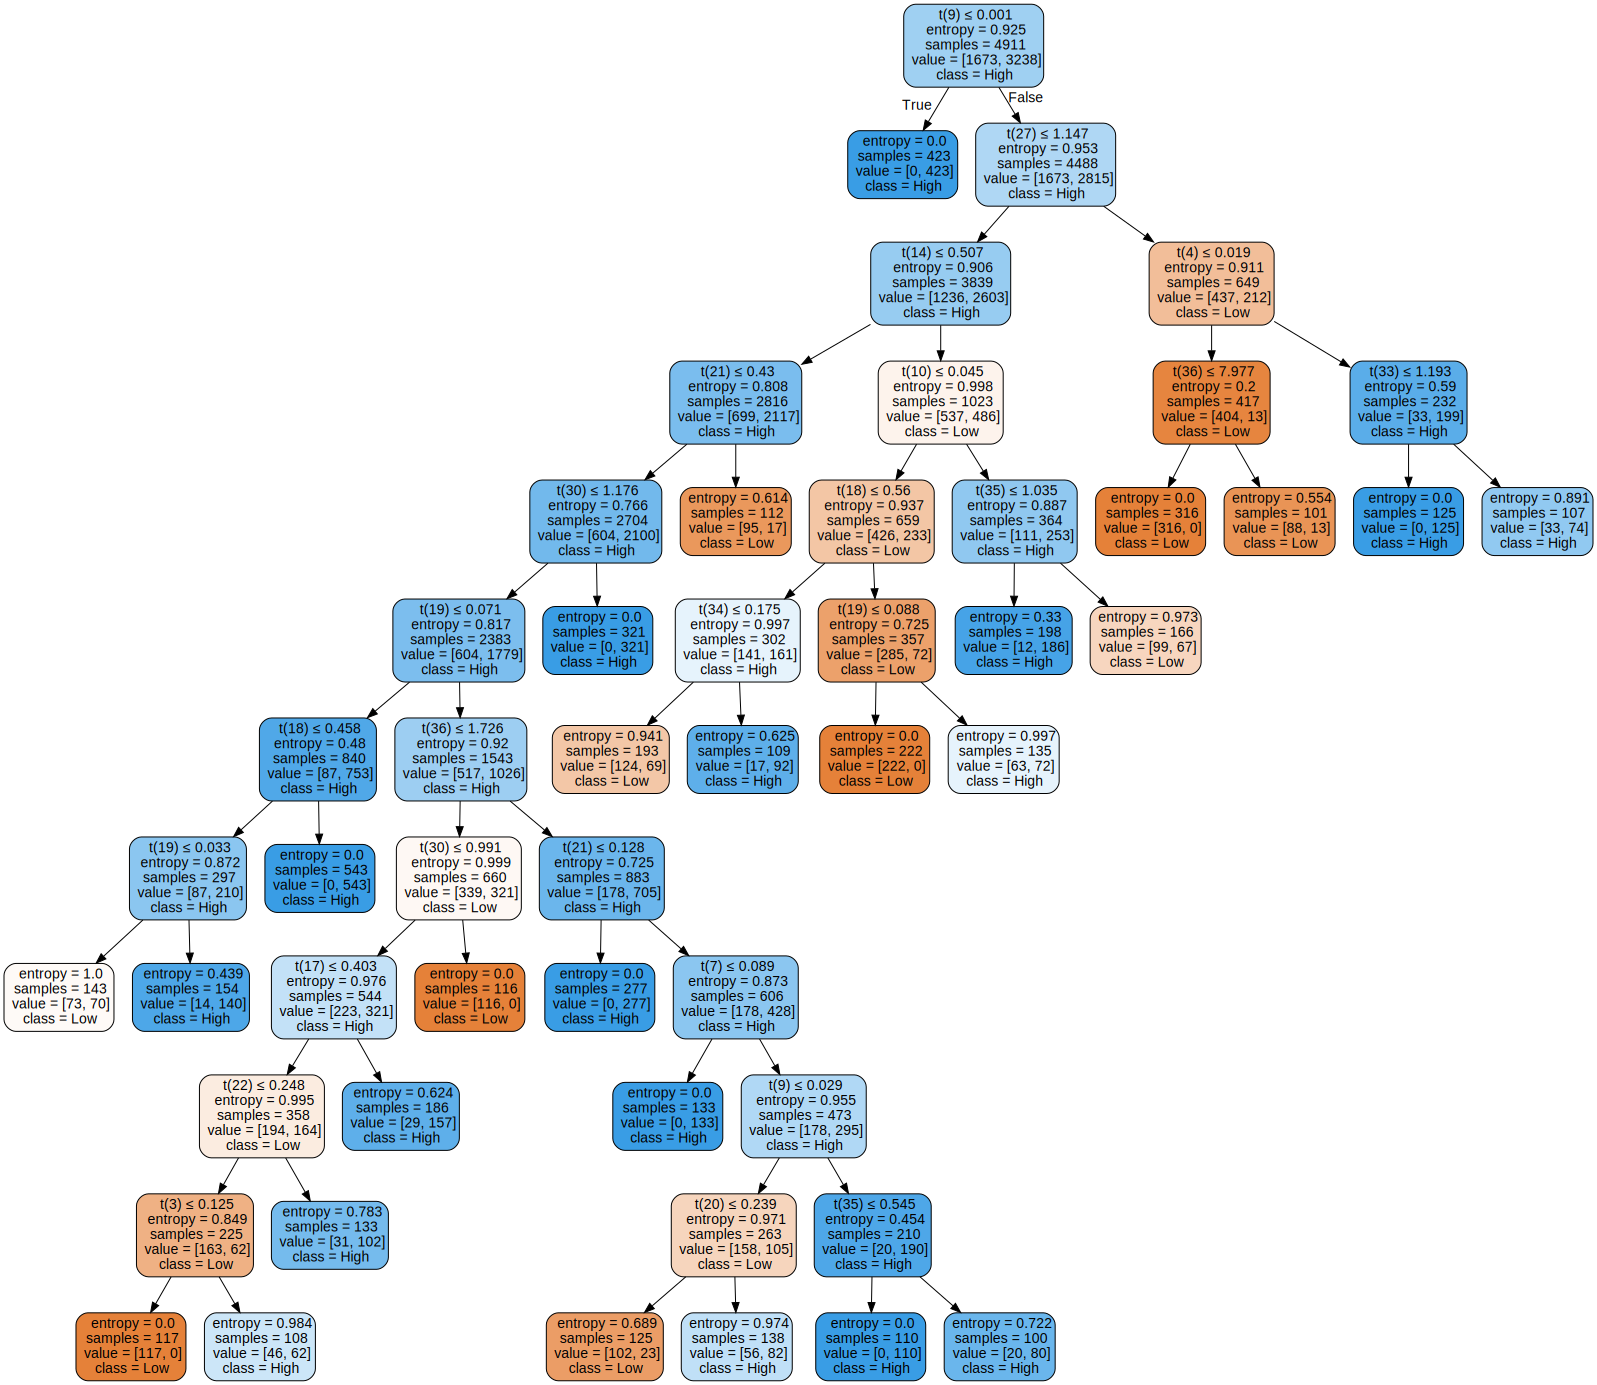

In [167]:
import graphviz
import sklearn.tree as tree
import shap

viz = tree.export_graphviz(model, out_file=None, 
                     feature_names=[f"t({i})" for i in range(37)],  
                     class_names=["Low", "High"],  
                     filled=True, rounded=True,
                     special_characters=True) 
graph = graphviz.Source(viz)
graph

In [74]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
explainer = shap.KernelExplainer(model.predict_proba, background)
shap_values = explainer.shap_values(X_test[np.random.choice(X_test.shape[0], 100, replace=False)])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

A Jupyter Widget

KeyboardInterrupt: 

In [31]:
model = LogisticRegression()

model = model.fit(X_n,y)
pred = model.predict_proba(X_n)[:,1]
model.score(X_n, y)

0.7781510893911627

In [32]:
mean_rank = df_box.groupby("idx").mean()["rank"].values
min_rank = df_box.groupby("idx").min()["rank"].values

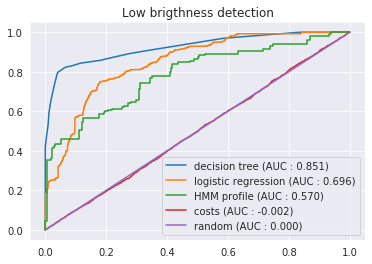

In [35]:
legs = []

fpr, tpr, _ = roc_curve(1-y, -pred_test)
plt.plot(fpr, tpr)
legs.append(f"decision tree (AUC : {2*auc(fpr, tpr)-1:.3f})")

fpr, tpr, _ = roc_curve(1-y, -pred)
plt.plot(fpr, tpr)
legs.append(f"logistic regression (AUC : {2*auc(fpr, tpr)-1:.3f})")

fpr, tpr, _ = roc_curve(1-y, cos_sim)
plt.plot(fpr, tpr)
legs.append(f"HMM profile (AUC : {2*auc(fpr, tpr)-1:.3f})")

fpr, tpr, _ = roc_curve(1-y, -costs)
plt.plot(fpr, tpr)
legs.append(f"costs (AUC : {2*auc(fpr, tpr)-1:.3f})")


# fpr, tpr, _ = roc_curve(1-y, -min_rank)
# plt.plot(fpr, tpr)
# legs.append(f"min rank (AUC : {2*auc(fpr, tpr)-1:.3f})")

plt.plot([0,1], [0,1])
legs.append(f"random (AUC : {0:.3f})")

plt.legend(legs)
plt.title("Low brigthness detection")
plt.show()

### PF00397

In [140]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, BayesianRidge, RidgeClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import StratifiedKFold, KFold

In [141]:
df = pd.read_csv(f"{DATA}/{DATASET}/generated_sequences.csv")
df["folded"] = df.id.apply(lambda x : int(x[0] == "*"))
df.index = df.id.apply(lambda x : x.split("*")[-1])

In [142]:
costs = []
cs, ts = all_costs2[0], all_transitions[0]
for k, v, t in zip(data.keys(), cs, ts):
    t = t - torch.log(torch.exp(t).sum(2).sum(1)).view(-1,1,1)
    tr = []
    for i in range(10):
        tr.append(np.trace(torch.exp(t).numpy(), offset = i, axis1 = 1, axis2 = 2))
    tr = np.array(tr).T

    costs.append((k, k[0], 
              df.loc[k].folded, 
              v[1].item(), 
              torch.max(v[0],1)[0],tr))
    
folded_nat2 = np.array([x[-1] for x in costs if x[1] == "N" and x[2] == 1]).mean(0)
# unfolded_nat = np.array([x[-1] for x in costs if x[1] == "N" and x[2] == 0]).mean(0)

folded_gen_div_folded = np.array([(folded_nat2 * (np.log(folded_nat2+1e-8) - np.log(x[-1]+1e-8))).sum(-1) for x in costs if x[1] == "C" and x[2] == 1])
unfolded_gen_div_folded = np.array([(folded_nat2 * (np.log(folded_nat2+1e-8) - np.log(x[-1]+1e-8))).sum(-1) for x in costs if x[1] == "C" and x[2] == 0])
folded_nat_div_folded = np.array([(folded_nat2 * (np.log(folded_nat2+1e-8) - np.log(x[-1]+1e-8))).sum(-1) for x in costs if x[1] == "N" and x[2] == 1])
unfolded_nat_div_folded = np.array([(folded_nat2 * (np.log(folded_nat2+1e-8) - np.log(x[-1]+1e-8))).sum(-1) for x in costs if x[1] == "N" and x[2] == 0])

AttributeError: 'list' object has no attribute 'keys'

In [143]:
plt.plot(unfolded_gen_div_folded.mean(0)/folded_gen_div_folded.mean(0) -1)
plt.plot(folded_gen_div_folded.mean(0)/folded_gen_div_folded.mean(0) -1)
plt.legend(["Not Folding", "Folding"])
plt.title("""Mean KL divergence to the reference distribution for 
            folding and unfolding proteins (Relative gap)""")
plt.ylim(-0.1)
plt.show()

NameError: name 'unfolded_gen_div_folded' is not defined

In [82]:
gen_div = np.concatenate([folded_gen_div_folded, unfolded_gen_div_folded])
y_gen = np.array([1]*folded_gen_div_folded.shape[0]+[0]*unfolded_gen_div_folded.shape[0])
X_gen = np.argsort(gen_div,0)
scaler = StandardScaler()
X_n = scaler.fit_transform(gen_div)
s = folded_gen_div_folded.shape[0]

nat_div = np.concatenate([folded_nat_div_folded, unfolded_nat_div_folded])
y_nat = np.array([1]*folded_nat_div_folded.shape[0]+[0]*unfolded_nat_div_folded.shape[0])
X_nat = np.argsort(nat_div,0)
s_nat = folded_nat_div_folded.shape[0]

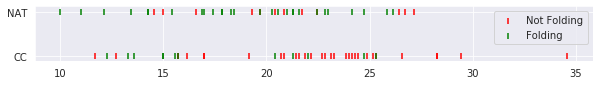

In [87]:
plt.figure(figsize = (10,1))

plt.scatter(np.mean(X_gen,1)[s:],y_gen[s:]*0, c="r", marker = "|")
plt.scatter(np.mean(X_gen,1)[:s],y_gen[:s]*0, c="g", marker = "|")

plt.scatter(np.mean(X_nat,1)[s_nat:],y_nat[s_nat:]*0+1, c="r", marker = "|")
plt.scatter(np.mean(X_nat,1)[:s_nat],y_nat[:s_nat]*0+1, c="g", marker = "|")

plt.legend(["Not Folding", "Folding"])
plt.yticks([0,1],["CC","NAT"])
# plt.xlim([0,1])
plt.show()

In [112]:
skf = KFold(43, shuffle = True)
pred = np.zeros(y.shape)
score = 0
for train_index, test_index in skf.split(X_n, y):
    X_train, X_test = X_n[train_index], X_n[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression()
    model = model.fit(X_train,y_train)
    pred[test_index] = model.predict_proba(X_test)[:,1]
    score += model.score(X_test, y_test)
score = score/43
score

0.7209302325581395

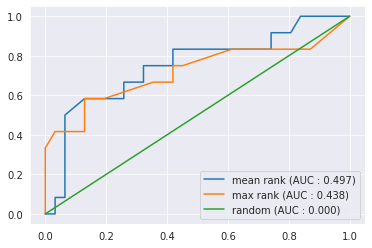

In [71]:
# for i in range(argsort_gendiv.shape[1]):
#     fpr, tpr, _ = roc_curve(y, -argsort_gendiv[:,i])
#     plt.plot(fpr, tpr)
legs = []

fpr, tpr, _ = roc_curve(y, -np.mean(X,1))
plt.plot(fpr, tpr)
legs.append(f"mean rank (AUC : {2*auc(fpr, tpr)-1:.3f})")

fpr, tpr, _ = roc_curve(y, -np.max(X,1))
plt.plot(fpr, tpr)
legs.append(f"max rank (AUC : {2*auc(fpr, tpr)-1:.3f})")

plt.plot([0,1], [0,1])
legs.append(f"random (AUC : {0:.3f})")

plt.legend(legs)
plt.show()

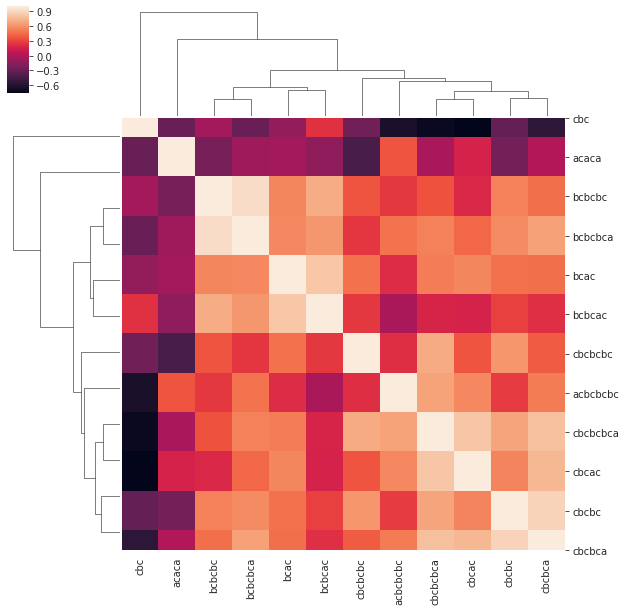

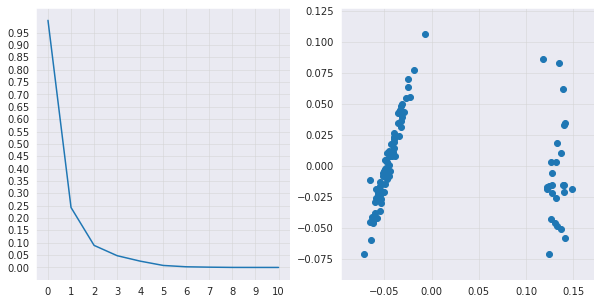

In [110]:
from sklearn.decomposition import PCA
all_costs = safe_costs
ax = sns.clustermap(np.corrcoef(all_costs), yticklabels = c_patterns, xticklabels = c_patterns)
# ax.set_xticklabels(rotation=45)
plt.show()

plt.figure(figsize = (10,5))
plt.subplot(121)
pca_ = PCA()
pca_ = pca_.fit(all_costs.T)
plt.plot([1]+list(1-np.cumsum(pca_.explained_variance_ratio_))[:10])
plt.xticks(range(min(all_costs.shape[0],11)))
plt.yticks(np.arange(0,1,0.05))
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5)

plt.subplot(122)
plt.scatter(pca_.transform(all_costs.T)[:,0], pca_.transform(all_costs.T)[:,1])
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5)
plt.show()

## No Pattern Matching

In [7]:
from secondary_structure.data import HMM_Data
DATA = "/home/cyril/Documents/These/data/"
train_dataset = HMM_Data(f"{DATA}/secondary_structure/training_set")
bboxes = [[],[],[]]
T = np.zeros((4,4))
pi = np.zeros(4)
for s in train_dataset.bbox:
    last_bb = None
    for bb in s:
        idx = np.argmax(bb[2:])
        bboxes[idx].append(int(bb[1]-bb[0]))
        if last_bb is not None:
            T[last_bb, idx] += 1
            T[idx, last_bb] += 1
        else:
            pi[idx] +=1
        last_bb = idx
    pi[last_bb]+=1
T[:,3] = pi
T[3,3] = 1
for i in range(T.shape[0]):
    T[i] /= T[i].sum()
    
E = np.zeros((3,33))
E[0, :33] = (np.bincount(bboxes[0])/len(bboxes[0]))[:33]
E[1, :21] = (np.bincount(bboxes[1])/len(bboxes[1]))[:21]
E[2, :5] = (np.bincount(bboxes[2])/len(bboxes[1]))[:5]
pi = T[:,3]
T, E, pi = np.log(T), np.log(E), np.log(pi)

MAX_SIZE = 400
e = E.shape[-1]
mask = np.ones((4,MAX_SIZE,MAX_SIZE))*(-np.inf)
for i in range(MAX_SIZE - e):
    mask[:3, i, i:i+e] = E
    mask[3,i,i] = 0
T = T.reshape(*T.shape, 1,1)
pi = pi.reshape(4,1)

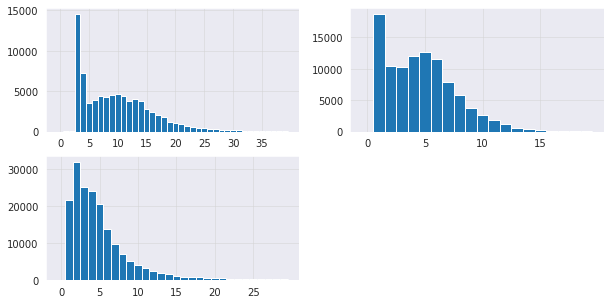

In [4]:
sizes = [40, 20, 30]

plt.figure(figsize = (10,5))
for i, (bbox, size) in enumerate(zip(bboxes, sizes)):
    plt.subplot(2,2,i+1)
    plt.hist(np.clip(bbox,0, size), bins = [i-0.5 for i in range(size+1)])
    plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(0,size,5))
plt.show()

In [48]:
EPS = 1e-5

class NoPatternMatching(object):
    def __init__(self, MAX_SIZE =300):
        self.MAX_SIZE = MAX_SIZE
    
    def match(self, y):
        N = y.size(0)
        P = self.P_(y)
        Q = mask[:,:N+1,:N+1]
        Q = Q.view(1, *Q.size(0))
        ll = self.LL(P,Q)[-1][-1,-1]
        s, boxes, _ = self.MLL(P,Q)
        return s, ll
    
    def LL(self,P,Q):
        N = P.size(-1)-1
        def sum_alpha():
            LL = []
            last_ll = P[0,:,0]+Q[0,:,0]+pi
            last_ll = last_ll.view(-1,1,N+1,1)
            LL.append(last_ll)
            for _ in range(N):
                ll = torch.log(torch.exp(P + Q + last_ll).sum(2).sum(0))
                if (ll[-1, -1] - last_ll[-1,0,-1,0]).abs() < EPS:
                    break
                last_ll = ll.view(-1,1,N+1,1)
                LL.append(last_ll)
            return [ll[:,0,:,0] for ll in LL]
        ll = sum_alpha()
        return ll
        
    def MLL(self,P,Q):
        N = P.size(-1)-1
        def max_alpha():
            LL = []
            last_ll = P[0,:,0]+Q[0,:,0]+pi
            last_ll = last_ll.view(-1,1,N+1,1)
            LL.append(last_ll)
            for _ in range(N):
                ll = (P + Q + last_ll).max(2)[0].max(0)[0]
                if np.abs((ll[-1, -1] - last_ll[-1,0,-1,0])) < EPS:
                    break
                last_ll = ll.view(-1,1,N+1,1)
                LL.append(last_ll)
            return [ll[:,0,:,0].flatten() for ll in LL]
    
        def argmax_alpha(alpha):
            c_star, t_star = 3,N
            mll = []
            for a in alpha[1:]:
                print((P[:,c_star,:,t_star] + Q[:,c_star,:,t_star] + np.zeros(T[:,c_star,:,0].shape)).flatten())
                amax = np.argmax((P[:,c_star,:,t_star] + Q[:,c_star,:,t_star] + T[:,c_star,:,0]*0).flatten() + a)
                c_star, t_star = amax//(N+1), amax%(N+1)
                mll.append((c_star, t_star))
            return mll
        alpha = max_alpha()
        mll = argmax_alpha(alpha[::-1])[::-1]
        
        m,M = -1, 0
        s = np.zeros(N)
        for c, t in mll:
            m, M, = M, t
            s[m:M] = c
        return np.array(s,dtype=int), mll, alpha
    
    def P_(self, C):
        N = C.size(0)
        P = torch.zeros((4,N+1,N+1))
        for i in range(N+1):
            P[:,i,:i+1] = -inf
            if i == N:
                break
            P[0,:i+1,i+1:] += C[i,0]
            P[1,:i+1,i+1:] += C[i,1]  
            P[2,:i+1,i+1:] += C[i,2]
        
        P[3] = -inf
        for i in range(N+1):
            P[3,i,i] = 0
        return P.view(1, *P.size())